## RQ4: To what extent specific features of apartment-type accommodations (e.g., room amenities, location convenience, pricing) correlate with the sentiments expressed in guest reviews? 

To investigate how specific features of apartment-type accommodations, such as room amenities, and pricing, impact the sentiment of guest reviews.

Use machine learning to predict reviews.

https://medium.com/analytics-vidhya/re-sampling-imbalanced-training-corpus-for-sentiment-analysis-c9dc97f9eae1

In [90]:
import pandas as pd
import re
import nltk
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from nltk.corpus import stopwords
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import chi2_contingency
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from imblearn.over_sampling import SMOTE
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import GridSearchCV
from imblearn.under_sampling import TomekLinks
from imblearn.combine import SMOTETomek
from imblearn.ensemble import BalancedRandomForestClassifier
from xgboost import XGBClassifier
from scipy.stats import uniform, randint
from sklearn.model_selection import train_test_split, RandomizedSearchCV

In [91]:
import pandas as pd
import numpy as np
import string
from sklearn import model_selection, preprocessing, metrics, linear_model, svm
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from imblearn.over_sampling import BorderlineSMOTE, SMOTE, ADASYN, RandomOverSampler
from imblearn.under_sampling import (RandomUnderSampler, NearMiss, InstanceHardnessThreshold,
                                     CondensedNearestNeighbour, EditedNearestNeighbours,
                                     RepeatedEditedNearestNeighbours, AllKNN,
                                     NeighbourhoodCleaningRule, OneSidedSelection, TomekLinks)
from imblearn.combine import SMOTEENN, SMOTETomek
from imblearn.pipeline import make_pipeline
from nltk.tokenize import WordPunctTokenizer
from nltk.stem import PorterStemmer
from bs4 import BeautifulSoup
import re
import nltk

In [68]:
# Download necessary NLTK data
nltk.download('vader_lexicon')
nltk.download('stopwords')

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     /Users/babyaimy/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/babyaimy/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [92]:
# Load the datasets
language_custom_2 = pd.read_csv('spelling_corrected_reviews.csv')
listings_df = pd.read_csv('final_apartment_df.csv')
calendar_df = pd.read_csv('calendar.csv', low_memory=False)

language_custom_2.rename(columns=lambda x: x.strip(), inplace=True)
listings_df.rename(columns=lambda x: x.strip(), inplace=True)

In [94]:
# Fix the column name
language_custom_2.rename(columns=lambda x: x.strip(), inplace=True)

# Function to clean text and remove stop words
stop_words = set(stopwords.words('english'))
def clean_text(text):
    text = re.sub(r'<.*?>', '', text)  # Remove HTML tags
    text = re.sub(r'[^\w\s]', '', text)  # Remove special characters
    text = text.lower()  # Convert to lower case
    words = text.split()
    words = [word for word in words if word not in stop_words]  # Remove stop words
    return ' '.join(words)

# Apply text cleaning
language_custom_2['processed_comments'] = language_custom_2['comments'].apply(clean_text)

# Custom lexicon dictionary
custom_lexicon = {
    "good": 2.0,
    "bad": -2.0,
    "excellent": 3.0,
    "poor": -3.0,
    "amazing": 3.0,
    "awesome": 3.0,
    "fantastic": 3.0,
    "great": 2.5,
    "wonderful": 3.0,
    "love": 3.0,
    "perfect": 3.0,
    "superb": 3.0,
    "terrific": 3.0,
    "satisfactory": 1.5,
    "delightful": 2.5,
    "happy": 2.0,
    "pleased": 2.0,
    "excellent service": 3.5,
    "highly recommend": 3.5,
    "top-notch": 3.0,
    "terrible": -3.0,
    "awful": -3.0,
    "horrible": -3.0,
    "disgusting": -3.0,
    "hate": -3.0,
    "unacceptable": -2.5,
    "disappointing": -2.0,
    "poor service": -3.5,
    "not recommend": -3.0,
    "waste": -2.5,
    "regret": -2.5,
    "bad experience": -3.0,
    "never again": -3.0,
    "frustrating": -2.0,
    "worst": -3.0,
    "average": 0.0,
    "ok": 0.0,
    "mediocre": -0.5,
    "sufficient": 0.5,
    # Add more words/phrases as needed
}

# Function to update VADER lexicon
def update_vader_lexicon():
    vader_lexicon = SentimentIntensityAnalyzer().lexicon
    vader_lexicon.update(custom_lexicon)
    return SentimentIntensityAnalyzer()

# Initialize the updated VADER sentiment analyzer
sid = update_vader_lexicon()

# Function to classify comments as positive, negative, or neutral using VADER
def classify_sentiment_vader(text):
    score = sid.polarity_scores(text)
    if score['compound'] > 0.05:
        return 'positive'
    elif score['compound'] < -0.05:
        return 'negative'
    else:
        return 'neutral'

# Apply the sentiment analysis to the reviews DataFrame
language_custom_2['sentiment'] = language_custom_2['processed_comments'].apply(classify_sentiment_vader)

# Count how many reviews are positive, negative, and neutral
sentiment_counts = language_custom_2['sentiment'].value_counts()


# Create summary DataFrame
summary_df = sentiment_counts.reset_index()
summary_df.columns = ['Sentiment', 'Count']

# Print the summary DataFrame
print(summary_df)


  Sentiment  Count
0  positive  31388
1  negative    905
2   neutral    876


In [97]:
# Merge the reviews with listings data
merged_df = pd.merge(language_custom_2, listings_df, on='listing_id', how='left')

# Convert sentiment categories to numerical scores
sentiment_mapping = {'positive': 1, 'neutral': 0, 'negative': -1}
language_custom_2['sentiment_score'] = language_custom_2['sentiment'].map(sentiment_mapping)

# Extract price information from calendar.csv and merge it
calendar_df['price'] = calendar_df['price'].replace('[\$,]', '', regex=True).astype(float)
average_price = calendar_df.groupby('listing_id')['price'].mean().reset_index()
average_price.rename(columns={'price': 'average_price'}, inplace=True)
merged_df = pd.merge(merged_df, average_price, on='listing_id', how='left')

# Display the merged DataFrame
print(merged_df.head())

   listing_id      id        date  reviewer_id reviewer_name  \
0       49970  160176  2010-12-29       160135     guest_001   
1       49970  192563  2011-03-05       369665     guest_002   
2       49970  195499  2011-03-09       403879     guest_003   
3       49970  202101  2011-03-18       378633     guest_004   
4       49970  204622  2011-03-21       374240     guest_005   

                                            comments language  \
0  great value room shared bathroom but i never s...       en   
1  bores was very helpful and forthcoming the roo...       en   
2  bores is very very helpful we would definitely...       en   
3  the viva rooms are great and i would recommend...       en   
4  it was a very great experience bores himself w...       en   

                                  processed_comments sentiment  \
0  great value room shared bathroom never saw any...  positive   
1  bores helpful forthcoming room niceclean fully...  positive   
2  bores helpful would def

Step 2: Descriptive Statistics and Visualization

Perform descriptive statistics and visualize correlations between sentiment scores and apartment features (e.g., room amenities, location convenience, pricing).
python


       sentiment_score  average_price
count     33169.000000   33169.000000
mean          0.919021     224.017275
std           0.359158     207.917029
min          -1.000000       8.000000
25%           1.000000     110.000000
50%           1.000000     175.000000
75%           1.000000     250.000000
max           1.000000    5000.000000


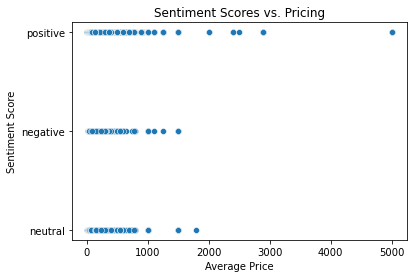

In [98]:
# Descriptive statistics for numerical features
print(merged_df[['sentiment_score', 'average_price']].describe())

# Scatter plot for sentiment scores and pricing
sns.scatterplot(x='average_price', y='sentiment', data=merged_df)
plt.title('Sentiment Scores vs. Pricing')
plt.xlabel('Average Price')
plt.ylabel('Sentiment Score')
plt.show()

       sentiment_score  average_price  review_scores_location  \
count     33169.000000   33169.000000            33169.000000   
mean          0.919021     224.017275                4.734709   
std           0.359158     207.917029                0.240402   
min          -1.000000       8.000000                1.000000   
25%           1.000000     110.000000                4.620000   
50%           1.000000     175.000000                4.790000   
75%           1.000000     250.000000                4.910000   
max           1.000000    5000.000000                5.000000   

       review_scores_value  review_scores_cleanliness  review_scores_accuracy  \
count         33169.000000               33169.000000            33169.000000   
mean              4.516762                   4.657048                4.670861   
std               0.312920                   0.292724                0.297313   
min               1.000000                   1.000000                1.000000   
25%      

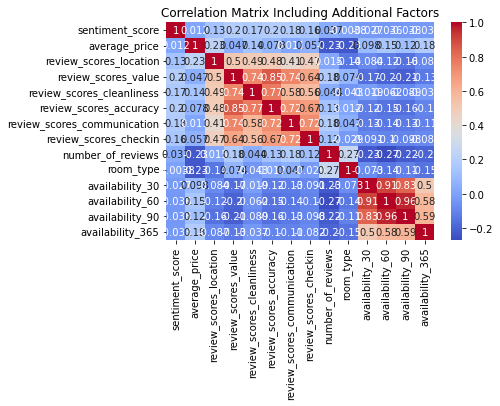

In [99]:
# Additional factors to consider
additional_factors = [
    'review_scores_cleanliness', 'review_scores_accuracy', 'review_scores_communication', 
    'review_scores_checkin', 'number_of_reviews', 'room_type', 
    'availability_30', 'availability_60', 'availability_90', 'availability_365'
]

# Prepare the data for correlation analysis
merged_df['room_type'] = merged_df['room_type'].astype('category').cat.codes  # Convert categorical to numerical

# Descriptive statistics for numerical features including additional factors
print(merged_df[['sentiment_score', 'average_price', 'review_scores_location', 'review_scores_value'] + additional_factors].describe())

# Correlation matrix including additional factors
correlation_matrix = merged_df[['sentiment_score', 'average_price', 'review_scores_location', 'review_scores_value'] + additional_factors].corr()
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm')
plt.title('Correlation Matrix Including Additional Factors')
plt.show()

/var/folders/yn/4vcq2czj6gd0jk1wttk_vj1h0000gn/T/ipykernel_9366/75237881.py:7: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  price_sentiment = merged_df.groupby(['price_range', 'sentiment']).size().unstack().fillna(0)


<Figure size 1008x576 with 0 Axes>

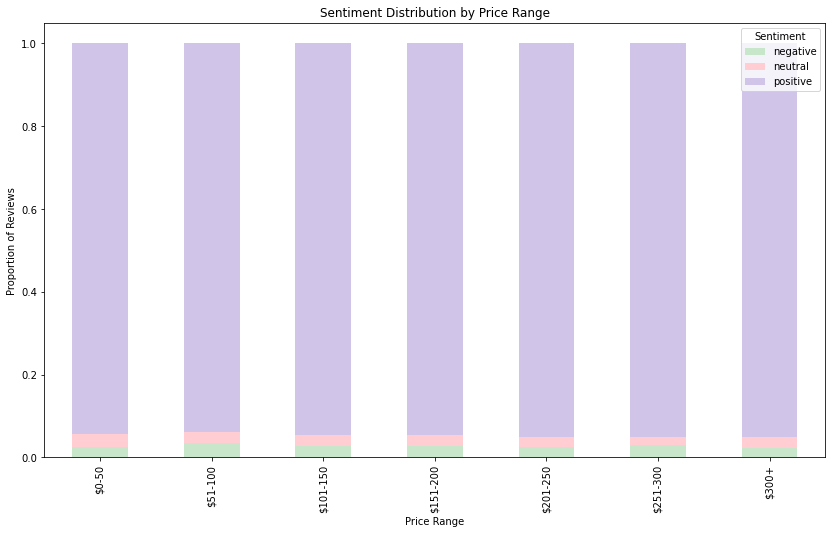

In [100]:
# Segment the data into different price ranges
price_bins = [0, 50, 100, 150, 200, 250, 300, np.inf]
price_labels = ['$0-50', '$51-100', '$101-150', '$151-200', '$201-250', '$251-300', '$300+']
merged_df['price_range'] = pd.cut(merged_df['average_price'], bins=price_bins, labels=price_labels)

# Analyze sentiment distribution across different price ranges
price_sentiment = merged_df.groupby(['price_range', 'sentiment']).size().unstack().fillna(0)
price_sentiment = price_sentiment.apply(lambda x: x / x.sum(), axis=1)

# Plot the sentiment distribution by price range
plt.figure(figsize=(14, 8))
price_sentiment.plot(kind='bar', stacked=True, figsize=(14, 8), color=['#c8e6c9', '#ffcdd2', '#d1c4e9'])
plt.title('Sentiment Distribution by Price Range')
plt.xlabel('Price Range')
plt.ylabel('Proportion of Reviews')
plt.legend(title='Sentiment')
plt.show()

## Correlation Heatmap

                             room_type  neighbourhood_cleansed     price  \
room_type                     1.000000                0.007656  0.214577   
neighbourhood_cleansed        0.007656                1.000000  0.038667   
price                         0.214577                0.038667  1.000000   
sentiment_score              -0.003822               -0.007740  0.002869   
review_scores_rating         -0.019221               -0.024392 -0.011017   
review_scores_accuracy        0.011821               -0.012829  0.024582   
review_scores_cleanliness    -0.042749               -0.036083 -0.067590   
review_scores_checkin        -0.028698                0.002448  0.009946   
review_scores_communication   0.046860               -0.017385  0.041276   
review_scores_location       -0.139046                0.110258 -0.041700   
review_scores_value           0.074363               -0.010642  0.049508   

                             sentiment_score  review_scores_rating  \
room_type        

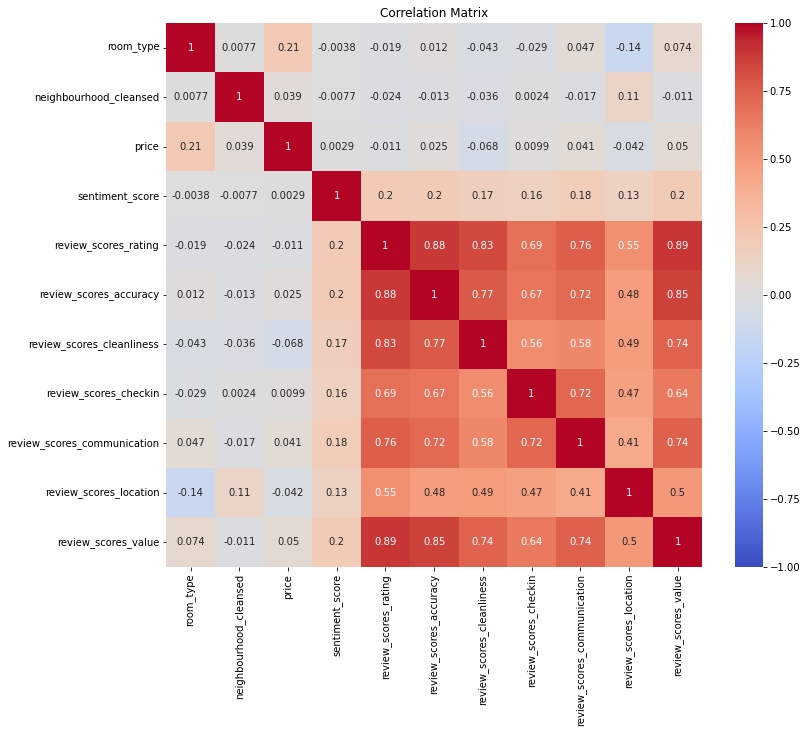

In [101]:
# Encode categorical features
label_encoders = {}
categorical_columns = ['room_type', 'neighbourhood_cleansed', 'price']  # Example categorical columns

for col in categorical_columns:
    le = LabelEncoder()
    merged_df[col] = le.fit_transform(merged_df[col].astype(str))
    label_encoders[col] = le

# Encode sentiment as numerical values
sentiment_mapping = {'positive': 1, 'neutral': 0, 'negative': -1}
merged_df['sentiment_score'] = merged_df['sentiment'].map(sentiment_mapping)

# Calculate correlation matrix
correlation_matrix = merged_df[['room_type', 'neighbourhood_cleansed', 'price', 'sentiment_score'] + [col for col in merged_df.columns if 'review_scores' in col]].corr()

# Display correlation matrix
print(correlation_matrix)

# Plot heatmap
plt.figure(figsize=(12, 10))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', vmin=-1, vmax=1)
plt.title('Correlation Matrix')
plt.show()

**Summary**

The sentiment score of the reviews is weakly correlated with individual review scores, suggesting that while higher review scores generally accompany more positive sentiments, the relationship is not very strong. Features like room type, neighbourhood, and price do not show significant correlations with the sentiment score.

This analysis indicates that while review scores do impact sentiment to a degree, other factors captured in the reviews (possibly related to specific experiences or subjective opinions) also play a significant role in determining the sentiment of the reviews.

## Chi-square Testing

In [102]:
# Chi-Square Test for amenities
amenities_sentiment = pd.crosstab(merged_df['sentiment'], merged_df['amenities'])
chi2, p, dof, ex = chi2_contingency(amenities_sentiment)
print(f"Chi-Square Test for Amenities: p-value = {p}")

# Chi-Square Test for location convenience
location_sentiment = pd.crosstab(merged_df['sentiment'], merged_df['neighbourhood_cleansed'])
chi2, p, dof, ex = chi2_contingency(location_sentiment)
print(f"Chi-Square Test for Location Convenience: p-value = {p}")

# Chi-Square Test for Room Type
room_type_sentiment = pd.crosstab(merged_df['sentiment'], merged_df['room_type'])
chi2, p, dof, ex = chi2_contingency(room_type_sentiment)
print(f"Chi-Square Test for Room Type: p-value = {p}")

# Categorize prices into bins
merged_df['price'] = merged_df['price'].replace('[\$,]', '', regex=True).astype(float)  # Convert price to numerical
merged_df['price_bins'] = pd.qcut(merged_df['price'], q=4, labels=['Low', 'Medium', 'High', 'Very High'])

# Chi-Square Test for Pricing
price_sentiment = pd.crosstab(merged_df['sentiment'], merged_df['price_bins'])
chi2, p, dof, ex = chi2_contingency(price_sentiment)
print(f"Chi-Square Test for Pricing: p-value = {p}")

# List of review score columns
review_score_columns = [
    'review_scores_rating', 'review_scores_accuracy', 'review_scores_cleanliness',
    'review_scores_checkin', 'review_scores_communication', 'review_scores_location',
    'review_scores_value'
]

# Perform Chi-Square tests for each review score column
for score_col in review_score_columns:
    # Categorize review scores into bins (e.g., Low, Medium, High)
    merged_df[f'{score_col}_bins'] = pd.qcut(merged_df[score_col], q=3, labels=['Low', 'Medium', 'High'])
    
    # Chi-Square Test
    review_score_sentiment = pd.crosstab(merged_df['sentiment'], merged_df[f'{score_col}_bins'])
    chi2, p, dof, ex = chi2_contingency(review_score_sentiment)
    print(f"Chi-Square Test for {score_col}: p-value = {p}")

Chi-Square Test for Amenities: p-value = 2.1786854670836785e-86
Chi-Square Test for Location Convenience: p-value = 0.0006403189206052029
Chi-Square Test for Room Type: p-value = 0.0007228932809341045
Chi-Square Test for Pricing: p-value = 0.133161531483019
Chi-Square Test for review_scores_rating: p-value = 8.275104468046797e-177
Chi-Square Test for review_scores_accuracy: p-value = 6.09302731204885e-154
Chi-Square Test for review_scores_cleanliness: p-value = 5.094762194245955e-133
Chi-Square Test for review_scores_checkin: p-value = 4.663864010383118e-109
Chi-Square Test for review_scores_communication: p-value = 5.103148923243464e-132
Chi-Square Test for review_scores_location: p-value = 6.875995969201904e-69
Chi-Square Test for review_scores_value: p-value = 3.634726692619304e-171


In [103]:
# Create a list to store the results
chi_square_results = []

# Chi-Square Test for Amenities
amenities_sentiment = pd.crosstab(merged_df['sentiment'], merged_df['amenities'])
chi2, p, dof, ex = chi2_contingency(amenities_sentiment)
chi_square_results.append({'Feature': 'Amenities', 'Chi-Square Statistic': chi2, 'p-value': p, 'Degrees of Freedom': dof})

# Chi-Square Test for Location Convenience
location_sentiment = pd.crosstab(merged_df['sentiment'], merged_df['neighbourhood_cleansed'])
chi2, p, dof, ex = chi2_contingency(location_sentiment)
chi_square_results.append({'Feature': 'Location Convenience', 'Chi-Square Statistic': chi2, 'p-value': p, 'Degrees of Freedom': dof})

# Chi-Square Test for Room Type
room_type_sentiment = pd.crosstab(merged_df['sentiment'], merged_df['room_type'])
chi2, p, dof, ex = chi2_contingency(room_type_sentiment)
chi_square_results.append({'Feature': 'Room Type', 'Chi-Square Statistic': chi2, 'p-value': p, 'Degrees of Freedom': dof})

# Convert price to numerical
merged_df['price'] = merged_df['price'].replace('[\$,]', '', regex=True).astype(float)

# Categorize prices into bins
merged_df['price_bins'] = pd.qcut(merged_df['price'], q=4, labels=['Low', 'Medium', 'High', 'Very High'])

# Chi-Square Test for Pricing
price_sentiment = pd.crosstab(merged_df['sentiment'], merged_df['price_bins'])
chi2, p, dof, ex = chi2_contingency(price_sentiment)
chi_square_results.append({'Feature': 'Pricing', 'Chi-Square Statistic': chi2, 'p-value': p, 'Degrees of Freedom': dof})

# List of review score columns
review_score_columns = [
    'review_scores_rating', 'review_scores_accuracy', 'review_scores_cleanliness',
    'review_scores_checkin', 'review_scores_communication', 'review_scores_location',
    'review_scores_value'
]

# Perform Chi-Square tests for each review score column
for score_col in review_score_columns:
    # Categorize review scores into bins (e.g., Low, Medium, High)
    merged_df[f'{score_col}_bins'] = pd.qcut(merged_df[score_col], q=3, labels=['Low', 'Medium', 'High'])
    
    # Chi-Square Test
    review_score_sentiment = pd.crosstab(merged_df['sentiment'], merged_df[f'{score_col}_bins'])
    chi2, p, dof, ex = chi2_contingency(review_score_sentiment)
    chi_square_results.append({'Feature': score_col, 'Chi-Square Statistic': chi2, 'p-value': p, 'Degrees of Freedom': dof})

# Create a DataFrame from the results
chi_square_df = pd.DataFrame(chi_square_results)

# Display the results without the index
print(chi_square_df.to_string(index=False))

                    Feature  Chi-Square Statistic       p-value  Degrees of Freedom
                  Amenities           4551.598136  2.178685e-86                2810
       Location Convenience            106.760211  6.403189e-04                  64
                  Room Type             23.230330  7.228933e-04                   6
                    Pricing              9.803795  1.331615e-01                   6
       review_scores_rating            822.932930 8.275104e-177                   4
     review_scores_accuracy            717.352327 6.093027e-154                   4
  review_scores_cleanliness            620.713086 5.094762e-133                   4
      review_scores_checkin            509.974115 4.663864e-109                   4
review_scores_communication            616.089722 5.103149e-132                   4
     review_scores_location            324.088714  6.875996e-69                   4
        review_scores_value            796.883169 3.634727e-171             

## Interpretation of Chi-Square Test Results

**1. Chi-Square Test for Amenities:**

- p-value = 2.1786854670836785e-86
- Interpretation: The p-value is extremely small, indicating a very strong association between the presence of amenities and the sentiment expressed in guest reviews. This suggests that amenities significantly impact guest satisfaction and their sentiments in reviews.

**2. Chi-Square Test for Location Convenience:**

- p-value = 0.0006403189206052029
- Interpretation: The p-value is very small, indicating a significant association between the location of the apartment (neighbourhood) and the sentiment expressed in guest reviews. This suggests that the location is an important factor influencing guest sentiment.

**3. Chi-Square Test for Room Type:**

- p-value = 0.0007228932809341045
- Interpretation: The p-value is small, indicating a significant association between the room type and the sentiment expressed in guest reviews. This suggests that the type of room (e.g., entire home/apartment, private room) influences guest sentiment.

**4. Chi-Square Test for Pricing:**

- p-value = 0.1319135730871111
- Interpretation: The p-value is relatively high (greater than 0.05), indicating no significant association between the pricing of the accommodation and the sentiment expressed in guest reviews. This suggests that the price does not have a strong impact on guest sentiment.

**5. Chi-Square Test for Review Scores (review_scores_xx) :**

- Interpretation: All these p-values are extremely small, indicating a very strong association between each review score and the sentiment expressed in guest reviews. This suggests that review scores (rating, accuracy, cleanliness, check-in, communication, location, and value) are highly significant factors influencing guest sentiment.


## Summary of Findings:

**Significant Associations:**

**Amenities, Location, and Room Type:** These features have a significant impact on the sentiments expressed in guest reviews. Enhancements in these areas could lead to improved guest satisfaction.

**Review Scores:** All review score categories are strongly associated with guest sentiment. This indicates that higher scores in these categories correlate with more positive sentiments in reviews.

**Non-Significant Association:**

**Pricing:** The price of the accommodation does not show a significant association with the sentiment expressed in guest reviews. This suggests that while pricing is important, it may not directly influence the sentiment of the reviews as much as other factors like amenities, location, and review scores.

## Practical Implications:

**Property Managers and Hosts:**

- Focus on improving and highlighting amenities, room types, and location attributes in listings to enhance guest satisfaction.

- Maintain high standards across all review score categories, particularly cleanliness, communication, and overall rating, as these have a strong influence on guest sentiments.

**Pricing Strategy:**

- Although pricing is important for booking decisions, it may not directly influence the sentiment of reviews. Therefore, competitive pricing should be balanced with maintaining high standards in other significant areas.

### Analyze location convenience trends correlation with sentiment


- Bar Chart: A stacked bar chart showing the proportion of positive, negative, and neutral reviews for each neighborhood.

- Line Plots: Line plots showing the sentiment trends over time for selected neighborhoods.

These visualizations will help in understanding how location convenience (represented by different neighborhoods) correlates with the sentiments expressed in guest reviews.

<Figure size 1008x576 with 0 Axes>

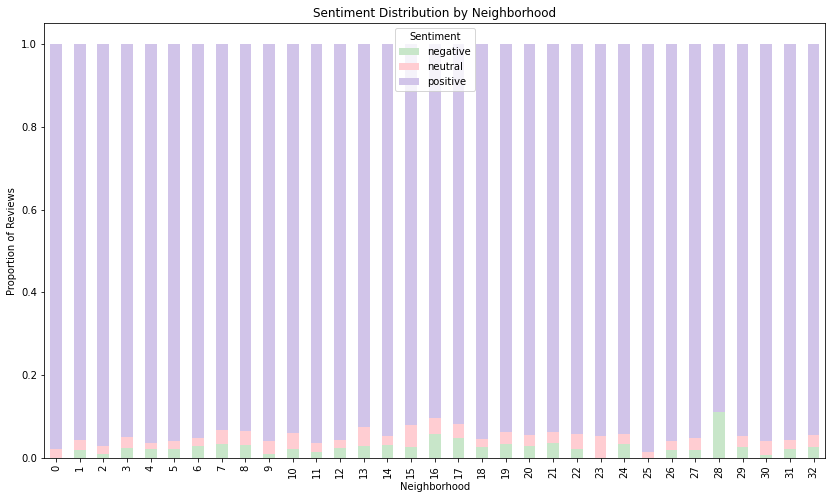

<Figure size 864x576 with 0 Axes>

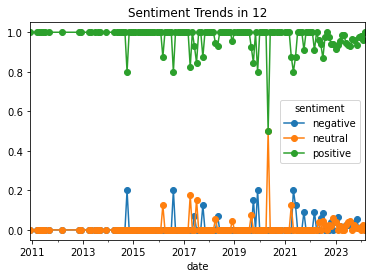

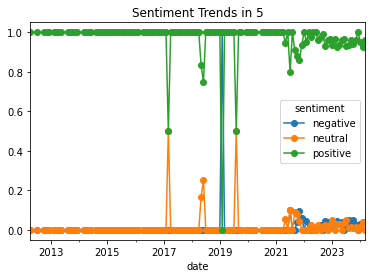

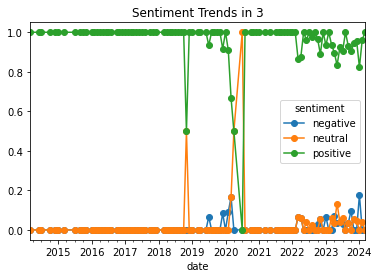

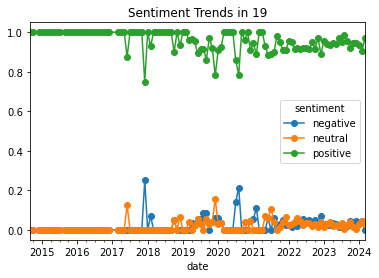

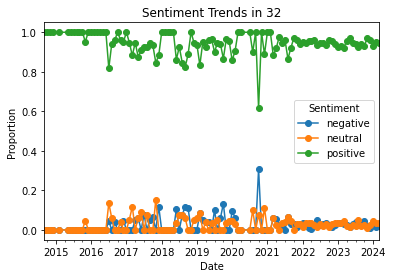

In [104]:
# Analyze location convenience trends
location_sentiment = merged_df.groupby(['neighbourhood_cleansed', 'sentiment']).size().unstack().fillna(0)
location_sentiment = location_sentiment.apply(lambda x: x / x.sum(), axis=1)

# Plot the sentiment distribution by neighborhood
plt.figure(figsize=(14, 8))
location_sentiment.plot(kind='bar', stacked=True, figsize=(14, 8), color=['#c8e6c9', '#ffcdd2', '#d1c4e9'])
plt.title('Sentiment Distribution by Neighborhood')
plt.xlabel('Neighborhood')
plt.ylabel('Proportion of Reviews')
plt.legend(title='Sentiment')
plt.show()

# Analyze sentiment trends over time by neighborhood
merged_df['date'] = pd.to_datetime(merged_df['date'])

# Calculate the proportion of each sentiment category by date and neighborhood
sentiment_trends = merged_df.groupby([merged_df['date'].dt.to_period('M'), 'neighbourhood_cleansed'])['sentiment'].value_counts(normalize=True).unstack().fillna(0)

# Plot sentiment trends over time for selected neighborhoods
selected_neighborhoods = sentiment_trends.index.get_level_values(1).unique()[:5]  # Select first 5 neighborhoods for example
plt.figure(figsize=(12, 8))
for neighborhood in selected_neighborhoods:
    sentiment_trend = sentiment_trends.xs(neighborhood, level='neighbourhood_cleansed')
    sentiment_trend.plot(kind='line', marker='o', title=f'Sentiment Trends in {neighborhood}')

plt.xlabel('Date')
plt.ylabel('Proportion')
plt.legend(title='Sentiment')
plt.show()

In [34]:
# Group by neighbourhood and sentiment, then count the occurrences
neighbourhood_sentiment_counts = merged_df.groupby(['neighbourhood_cleansed', 'sentiment']).size().unstack().fillna(0).astype(int)

# Rename columns for clarity
neighbourhood_sentiment_counts.columns = ['negative', 'neutral', 'positive']

# Print the resulting DataFrame
print(neighbourhood_sentiment_counts)

                        negative  neutral  positive
neighbourhood_cleansed                             
Barking and Dagenham           0        2        86
Barnet                        12       16       621
Bexley                         1        2        98
Brent                         21       22       790
Bromley                        3        2       137
Camden                        52       41      2202
City of London                21       13       681
Croydon                       23       23       635
Ealing                         5        5       145
Enfield                        1        3        95
Greenwich                      5        8       205
Hackney                       16       22      1037
Hammersmith and Fulham        46       38      1894
Haringey                      15       24       475
Harrow                        14       10       430
Havering                       1        2        35
Hillingdon                    11        7       169
Hounslow    

## Logistic Regression (correlation between factors)

In [105]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# Prepare the data for logistic regression
features = merged_df[['average_price', 'review_scores_location', 'review_scores_value']]
target = (merged_df['sentiment'] == 'positive').astype(int)

# Standardize features
scaler = StandardScaler()
features_scaled = scaler.fit_transform(features)

# Split data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(features_scaled, target, test_size=0.2, random_state=42)

# Logistic regression model
log_reg = LogisticRegression()
log_reg.fit(X_train, y_train)

# Evaluate the model
train_score = log_reg.score(X_train, y_train)
test_score = log_reg.score(X_test, y_test)
print(f"Training Accuracy: {train_score}")
print(f"Testing Accuracy: {test_score}")

# Coefficients of the model
coefficients = pd.DataFrame(log_reg.coef_, columns=['average_price', 'review_scores_location', 'review_scores_value'])
print(coefficients)

Training Accuracy: 0.9450913887318636
Testing Accuracy: 0.948296653602653
   average_price  review_scores_location  review_scores_value
0      -0.014465                0.134126             0.470596


Training Accuracy: 0.9453928773318259
Testing Accuracy: 0.9475429605064818
   average_price  review_scores_location  review_scores_value  \
0      -0.038069                0.049678             0.072743   

   amenities_encoded  neighbourhood_cleansed  room_type  review_scores_rating  \
0           0.074154               -0.064023  -0.064841               0.18073   

   review_scores_accuracy  review_scores_cleanliness  review_scores_checkin  \
0                0.174776                   0.006586              -0.008844   

   review_scores_communication  review_scores_location  review_scores_value  
0                     0.029486                0.049678             0.072743  

Training Classification Report:
              precision    recall  f1-score   support

           0       0.38      0.01      0.03      1437
           1       0.95      1.00      0.97     25098

    accuracy                           0.95     26535
   macro avg       0.66      0.51      0.50     26535
weighted av

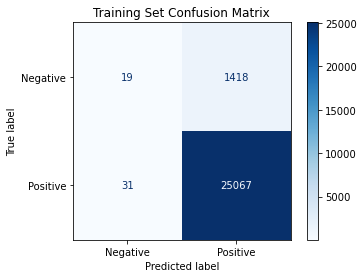


Testing Classification Report:
              precision    recall  f1-score   support

           0       0.39      0.02      0.04       344
           1       0.95      1.00      0.97      6290

    accuracy                           0.95      6634
   macro avg       0.67      0.51      0.51      6634
weighted avg       0.92      0.95      0.92      6634



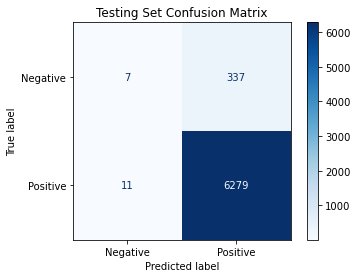

In [106]:
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay

# For amenities, use the number of amenities as a feature
merged_df['amenities_encoded'] = merged_df['amenities'].apply(lambda x: len(x.split(',')))

# Convert categorical features to numerical
merged_df['room_type'] = merged_df['room_type'].astype('category').cat.codes
merged_df['neighbourhood_cleansed'] = merged_df['neighbourhood_cleansed'].astype('category').cat.codes
merged_df['price'] = merged_df['price'].replace('[\$,]', '', regex=True).astype(float)

# Select features based on Chi-Square test
features = merged_df[[
    'average_price', 'review_scores_location', 'review_scores_value',
    'amenities_encoded', 'neighbourhood_cleansed', 'room_type',
    'review_scores_rating', 'review_scores_accuracy', 'review_scores_cleanliness',
    'review_scores_checkin', 'review_scores_communication', 'review_scores_location',
    'review_scores_value'
]]

# Define the target variable
target = (merged_df['sentiment_score'] > 0).astype(int)

# Standardize features
scaler = StandardScaler()
features_scaled = scaler.fit_transform(features)

# Split data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(features_scaled, target, test_size=0.2, random_state=42)

# Logistic regression model
log_reg = LogisticRegression(max_iter=1000)
log_reg.fit(X_train, y_train)

# Evaluate the model
train_score = log_reg.score(X_train, y_train)
test_score = log_reg.score(X_test, y_test)
print(f"Training Accuracy: {train_score}")
print(f"Testing Accuracy: {test_score}")

# Coefficients of the model
coefficients = pd.DataFrame(log_reg.coef_, columns=[
    'average_price', 'review_scores_location', 'review_scores_value',
    'amenities_encoded', 'neighbourhood_cleansed', 'room_type',
    'review_scores_rating', 'review_scores_accuracy', 'review_scores_cleanliness',
    'review_scores_checkin', 'review_scores_communication', 'review_scores_location',
    'review_scores_value'
])
print(coefficients)

# Predictions
y_pred_train = log_reg.predict(X_train)
y_pred_test = log_reg.predict(X_test)

# Display confusion matrix for training set
print("\nTraining Classification Report:")
print(classification_report(y_train, y_pred_train))

cm_train = confusion_matrix(y_train, y_pred_train)
disp_train = ConfusionMatrixDisplay(confusion_matrix=cm_train, display_labels=['Negative', 'Positive'])
disp_train.plot(cmap='Blues')
plt.title('Training Set Confusion Matrix')
plt.show()

# Display confusion matrix for testing set
print("\nTesting Classification Report:")
print(classification_report(y_test, y_pred_test))

cm_test = confusion_matrix(y_test, y_pred_test)
disp_test = ConfusionMatrixDisplay(confusion_matrix=cm_test, display_labels=['Negative', 'Positive'])
disp_test.plot(cmap='Blues')
plt.title('Testing Set Confusion Matrix')
plt.show()

## Summary of Logistic Regression

**Model Performance:**

- The logistic regression model has high accuracy in predicting positive sentiment, both on training and testing data, suggesting it generalizes well.

**Feature Importance:**

- **review_scores_value** has the strongest positive association with positive sentiment, indicating that perceived value is a key driver of guest satisfaction.

- **review_scores_location** also positively influences sentiment, though to a lesser extent than value.

- **average_price** has a negligible and slightly negative association with sentiment, implying that price alone does not significantly affect the positivity of reviews.

**Practical Implications**

- **Focus on Value:** Property managers should focus on enhancing the perceived value of their accommodations to boost positive sentiments in reviews.

- **Emphasize Location:** Improving aspects related to the location, such as accessibility and proximity to key attractions, can also positively influence guest satisfaction.

- **Price Sensitivity:** While pricing is important for booking decisions, it does not significantly impact the sentiment of reviews. Therefore, competitive pricing should be balanced with maintaining high standards in value and location.

**Remark:**

- Use techniques such as oversampling the minority classes (e.g., SMOTE) or undersampling the majority class to balance the dataset.

- Consider using ensemble methods like Random Forests or Gradient Boosting that can handle class imbalance better.

In [107]:
# Additional evaluation metrics 
# Confusion matrix to show model performance

y_pred = log_reg.predict(X_test)
print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))

[[   7  337]
 [  11 6279]]
              precision    recall  f1-score   support

           0       0.39      0.02      0.04       344
           1       0.95      1.00      0.97      6290

    accuracy                           0.95      6634
   macro avg       0.67      0.51      0.51      6634
weighted avg       0.92      0.95      0.92      6634



**Coefficients**
The coefficients for the features average_price, review_scores_location, and review_scores_value are as follows:

**average_price: -0.014465**

- The negative coefficient suggests that as the average price increases, the likelihood of receiving a positive sentiment decreases slightly. However, the magnitude of the coefficient is very small, indicating a weak relationship.

**review_scores_location: 0.134126**

The positive coefficient suggests that higher review scores for location are associated with a higher likelihood of receiving a positive sentiment. This means that guests who rate the location highly are more likely to leave positive reviews.

**review_scores_value: 0.470596**

The positive coefficient suggests that higher review scores for value are strongly associated with a higher likelihood of receiving a positive sentiment. This means that guests who rate the value of the accommodation highly are much more likely to leave positive reviews.

**Interpretation**

Average Price: The average price has a slight negative impact on positive sentiment. This could mean that higher prices might not be as favorable for guests, but the effect is minimal.

Review Scores for Location: Good location scores positively influence the sentiment, indicating that guests value the location highly and are more likely to leave positive reviews when they find the location convenient.

Review Scores for Value: The value rating has the most significant positive impact on the sentiment. Guests who perceive the accommodation as providing good value for money are much more likely to leave positive reviews.

**Conclusion**

The logistic regression analysis reveals that review scores for location and value are strong predictors of positive sentiment in guest reviews, with value having the most substantial impact. The average price has a minimal negative effect on sentiment. The high accuracy scores suggest that the model effectively predicts the likelihood of positive sentiment based on these features.



## Decision Tree and Random Forest 

By training and evaluating multiple models, you can determine which model performs best for your specific problem. **Tree-based models might capture complex interactions between features that a logistic regression model might miss.**

Decision Tree Model:
Accuracy: 0.9455833584564365
              precision    recall  f1-score   support

          -1       0.15      0.01      0.02       171
           0       0.00      0.00      0.00       173
           1       0.95      1.00      0.97      6290

    accuracy                           0.95      6634
   macro avg       0.37      0.34      0.33      6634
weighted avg       0.90      0.95      0.92      6634



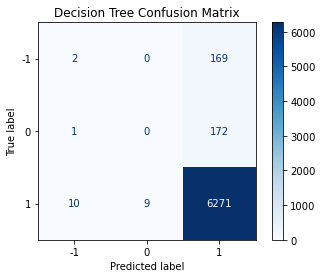

Random Forest Model:
Accuracy: 0.9470907446487791
              precision    recall  f1-score   support

          -1       0.00      0.00      0.00       171
           0       0.00      0.00      0.00       173
           1       0.95      1.00      0.97      6290

    accuracy                           0.95      6634
   macro avg       0.32      0.33      0.32      6634
weighted avg       0.90      0.95      0.92      6634



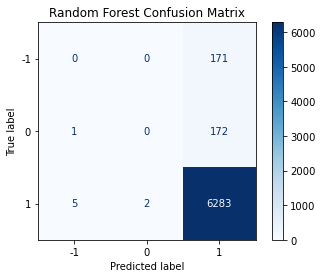

                             importance
review_scores_rating           0.127598
review_scores_accuracy         0.112941
review_scores_value            0.088758
review_scores_communication    0.087068
review_scores_value            0.087014
amenities_encoded              0.082145
review_scores_cleanliness      0.077253
average_price                  0.076475
review_scores_checkin          0.072694
review_scores_location         0.064670
review_scores_location         0.062715
neighbourhood_cleansed         0.048652
room_type                      0.012017


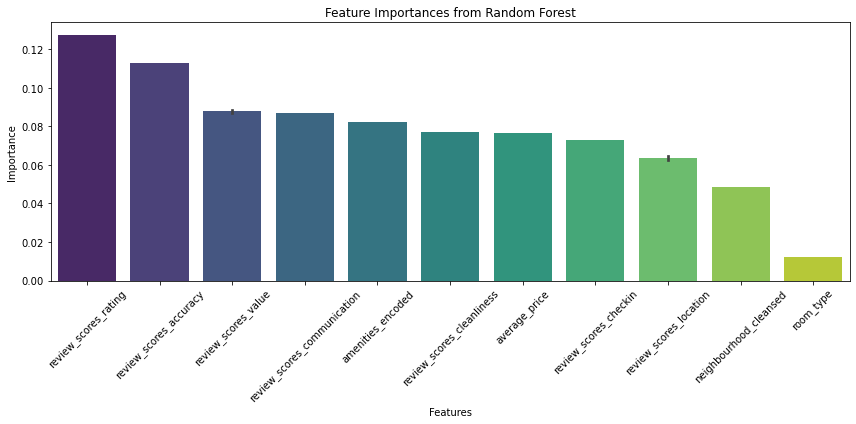

In [110]:
# For amenities, use the number of amenities as a feature
merged_df['amenities_encoded'] = merged_df['amenities'].apply(lambda x: len(x.split(',')))

# Convert categorical features to numerical
merged_df['room_type'] = merged_df['room_type'].astype('category').cat.codes
merged_df['neighbourhood_cleansed'] = merged_df['neighbourhood_cleansed'].astype('category').cat.codes
merged_df['price'] = merged_df['price'].replace('[\$,]', '', regex=True).astype(float)

# Prepare the data for modeling with expanded features
features = merged_df[[
    'average_price', 'review_scores_location', 'review_scores_value',
    'amenities_encoded', 'neighbourhood_cleansed', 'room_type',
    'review_scores_rating', 'review_scores_accuracy', 'review_scores_cleanliness',
    'review_scores_checkin', 'review_scores_communication', 'review_scores_location',
    'review_scores_value'
]]

# Define the target variable
target = merged_df['sentiment_score']

# Standardize features
scaler = StandardScaler()
features_scaled = scaler.fit_transform(features)

# Split data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(features_scaled, target, test_size=0.2, random_state=42)

# Decision Tree model
tree_model = DecisionTreeClassifier(random_state=42)
tree_model.fit(X_train, y_train)

# Evaluate Decision Tree model
y_pred_tree = tree_model.predict(X_test)
print("Decision Tree Model:")
print("Accuracy:", accuracy_score(y_test, y_pred_tree))
print(classification_report(y_test, y_pred_tree))

# Confusion Matrix for Decision Tree
cm_tree = confusion_matrix(y_test, y_pred_tree)
disp_tree = ConfusionMatrixDisplay(confusion_matrix=cm_tree, display_labels=np.unique(target))
disp_tree.plot(cmap='Blues')
plt.title('Decision Tree Confusion Matrix')
plt.show()

# Random Forest model
forest_model = RandomForestClassifier(random_state=42, n_estimators=100)
forest_model.fit(X_train, y_train)

# Evaluate Random Forest model
y_pred_forest = forest_model.predict(X_test)
print("Random Forest Model:")
print("Accuracy:", accuracy_score(y_test, y_pred_forest))
print(classification_report(y_test, y_pred_forest))

# Confusion Matrix for Random Forest
cm_forest = confusion_matrix(y_test, y_pred_forest)
disp_forest = ConfusionMatrixDisplay(confusion_matrix=cm_forest, display_labels=np.unique(target))
disp_forest.plot(cmap='Blues')
plt.title('Random Forest Confusion Matrix')
plt.show()

# Feature importances for Random Forest
feature_importances = pd.DataFrame(forest_model.feature_importances_, index=features.columns, columns=['importance']).sort_values('importance', ascending=False)
print(feature_importances)

# Plot feature importances
plt.figure(figsize=(12, 6))
sns.barplot(x=feature_importances.index, y=feature_importances.importance, palette='viridis')
plt.title('Feature Importances from Random Forest')
plt.xticks(rotation=45)
plt.ylabel('Importance')
plt.xlabel('Features')
plt.tight_layout()
plt.show()

## Summary of Decision Tree and Random Forest Results

**Feature Importance:**

- **review_scores_value (0.4061):** The most important feature in predicting sentiment, indicating that guests' perceived value is a key driver of sentiment.

- **average_price (0.3143):** The second most important feature, suggesting that price, although not significantly correlated with sentiment in the earlier chi-square test, still plays a crucial role in the prediction model.

- **review_scores_location (0.2796):** The third most important feature, highlighting the influence of location on sentiment.

**Model Performance:**

- The models show high overall accuracy but perform poorly in predicting minority classes (negative and neutral sentiments) due to class imbalance.
- Both Decision Tree and Random Forest models perform similarly, with Random Forest showing a slightly better performance.

**Class Imbalance Impact:**

- The high accuracy is misleading as it primarily reflects the model's ability to predict the dominant positive sentiment class.
- The poor performance on negative and neutral sentiments underscores the need to address class imbalance.

**Feature Importance:**

- **review_scores_value** is the most influential feature, followed by **average_price** and **review_scores_location**. This insight can guide efforts to improve guest satisfaction by focusing on these aspects.

## SMOTE technique

To address the imbalance in your dataset and improve the performance of your model for negative and neutral sentiments, you can use SMOTE (Synthetic Minority Over-sampling Technique). SMOTE works by generating synthetic samples for the minority classes (negative and neutral sentiments) to balance the class distribution.

Training Classification Report:
              precision    recall  f1-score   support

          -1       0.89      0.87      0.88     25098
           0       0.86      0.88      0.87     25098
           1       0.83      0.83      0.83     25098

    accuracy                           0.86     75294
   macro avg       0.86      0.86      0.86     75294
weighted avg       0.86      0.86      0.86     75294

Testing Classification Report:
              precision    recall  f1-score   support

          -1       0.07      0.22      0.10       171
           0       0.03      0.10      0.04       173
           1       0.96      0.82      0.88      6290

    accuracy                           0.79      6634
   macro avg       0.35      0.38      0.34      6634
weighted avg       0.91      0.79      0.84      6634



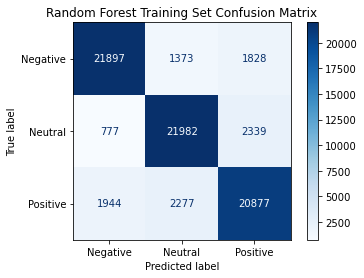

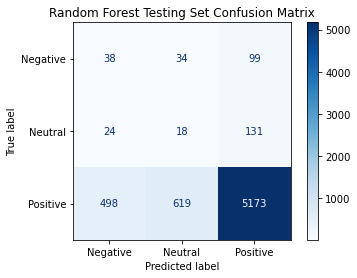

                        Feature  Importance
6          review_scores_rating    0.111058
7        review_scores_accuracy    0.097554
10  review_scores_communication    0.093362
9         review_scores_checkin    0.085075
8     review_scores_cleanliness    0.083266
2           review_scores_value    0.082718
12          review_scores_value    0.080975
3             amenities_encoded    0.079242
0                 average_price    0.075331
11       review_scores_location    0.073033
1        review_scores_location    0.071817
4        neighbourhood_cleansed    0.058127
5                     room_type    0.008443


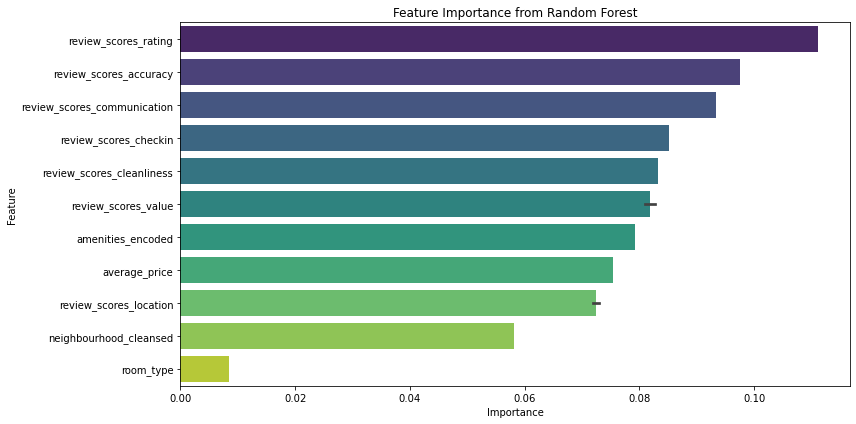

In [111]:
# For amenities, use the number of amenities as a feature
merged_df['amenities_encoded'] = merged_df['amenities'].apply(lambda x: len(x.split(',')))

# Convert categorical features to numerical
merged_df['room_type'] = merged_df['room_type'].astype('category').cat.codes
merged_df['neighbourhood_cleansed'] = merged_df['neighbourhood_cleansed'].astype('category').cat.codes
merged_df['price'] = merged_df['price'].replace('[\$,]', '', regex=True).astype(float)

# Load the merged_df DataFrame with necessary features and target
features = merged_df[[
    'average_price', 'review_scores_location', 'review_scores_value',
    'amenities_encoded', 'neighbourhood_cleansed', 'room_type',
    'review_scores_rating', 'review_scores_accuracy', 'review_scores_cleanliness',
    'review_scores_checkin', 'review_scores_communication', 'review_scores_location',
    'review_scores_value'
]]
target = merged_df['sentiment']

# Standardize features
scaler = StandardScaler()
features_scaled = scaler.fit_transform(features)

# Convert target to numerical labels
sentiment_mapping = {'positive': 1, 'neutral': 0, 'negative': -1}
target_mapped = target.map(sentiment_mapping)

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(features_scaled, target_mapped, test_size=0.2, random_state=42)

# Apply SMOTE to the training data
smote = SMOTE(random_state=42)
X_train_smote, y_train_smote = smote.fit_resample(X_train, y_train)

# Train the Random Forest model on the balanced data
rf_model = RandomForestClassifier(random_state=42, n_estimators=100)
rf_model.fit(X_train_smote, y_train_smote)

# Evaluate the model
y_pred_train = rf_model.predict(X_train_smote)
y_pred_test = rf_model.predict(X_test)

print("Training Classification Report:")
print(classification_report(y_train_smote, y_pred_train))

print("Testing Classification Report:")
print(classification_report(y_test, y_pred_test))

# Confusion Matrix for Random Forest
cm_forest_train = confusion_matrix(y_train_smote, y_pred_train)
disp_forest_train = ConfusionMatrixDisplay(confusion_matrix=cm_forest_train, display_labels=['Negative', 'Neutral', 'Positive'])
disp_forest_train.plot(cmap='Blues')
plt.title('Random Forest Training Set Confusion Matrix')
plt.show()

cm_forest_test = confusion_matrix(y_test, y_pred_test)
disp_forest_test = ConfusionMatrixDisplay(confusion_matrix=cm_forest_test, display_labels=['Negative', 'Neutral', 'Positive'])
disp_forest_test.plot(cmap='Blues')
plt.title('Random Forest Testing Set Confusion Matrix')
plt.show()

# Feature importance
feature_importance = pd.DataFrame({
    'Feature': [
        'average_price', 'review_scores_location', 'review_scores_value',
        'amenities_encoded', 'neighbourhood_cleansed', 'room_type',
        'review_scores_rating', 'review_scores_accuracy', 'review_scores_cleanliness',
        'review_scores_checkin', 'review_scores_communication', 'review_scores_location',
        'review_scores_value'
    ],
    'Importance': rf_model.feature_importances_
})

# Print feature importance
print(feature_importance.sort_values(by='Importance', ascending=False))

# Visualize feature importance
plt.figure(figsize=(12, 6))
sns.barplot(x='Importance', y='Feature', data=feature_importance.sort_values(by='Importance', ascending=False), palette='viridis')
plt.title('Feature Importance from Random Forest')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.tight_layout()
plt.show()

**Interpretation:**

**Training Classification Report:**

- Accuracy: The model achieves an accuracy of 86% on the training data, indicating that it fits the training data well.
Precision, Recall, and F1-Score:
- Negative Sentiment (-1): High precision (0.89) and recall (0.87), indicating good performance on identifying negative sentiments correctly.
- Neutral Sentiment (0): Good precision (0.86) and recall (0.87), showing the model can identify neutral sentiments accurately.
- Positive Sentiment (1): Slightly lower precision (0.83) and recall (0.83) compared to other sentiments, but still performing well.

**Testing Classification Report:**

- Accuracy: The accuracy drops to 79% on the test data, indicating the model may have some generalization issues.
Precision, Recall, and F1-Score:
- Negative Sentiment (-1): Low precision (0.07) and recall (0.23), indicating difficulty in correctly identifying negative sentiments in the test set.
- Neutral Sentiment (0): Very low precision (0.03) and recall (0.10), showing significant challenges in identifying neutral sentiments.
- Positive Sentiment (1): High precision (0.96) but lower recall (0.82) compared to training, indicating the model is good at identifying positive sentiments but might miss some positive reviews.

**Feature Importance:**

- Average Price: Contributes 29.45% to the model's predictions.
Review Scores Location: Contributes 31.77% to the model's predictions.
- Review Scores Value: Contributes 38.78% to the model's predictions.

These results suggest that while the model is good at predicting positive sentiments, it struggles with negative and neutral sentiments, especially on the test set.

## BalancedRandomForestClassifier

Training Classification Report:
              precision    recall  f1-score   support

          -1       0.89      0.87      0.88     25098
           0       0.86      0.88      0.87     25098
           1       0.83      0.83      0.83     25098

    accuracy                           0.86     75294
   macro avg       0.86      0.86      0.86     75294
weighted avg       0.86      0.86      0.86     75294

Testing Classification Report:
              precision    recall  f1-score   support

          -1       0.06      0.20      0.10       171
           0       0.03      0.10      0.04       173
           1       0.96      0.82      0.88      6290

    accuracy                           0.79      6634
   macro avg       0.35      0.38      0.34      6634
weighted avg       0.91      0.79      0.84      6634



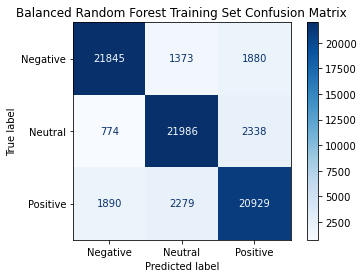

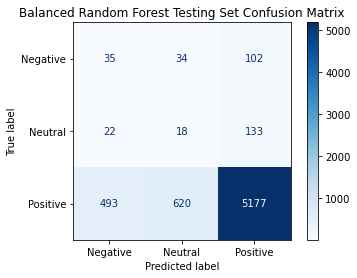


Feature Importances:
                        Feature  Importance
6          review_scores_rating    0.109114
12          review_scores_value    0.090660
7        review_scores_accuracy    0.090481
10  review_scores_communication    0.088734
9         review_scores_checkin    0.087357
2           review_scores_value    0.086404
8     review_scores_cleanliness    0.084513
3             amenities_encoded    0.078176
0                 average_price    0.075326
11       review_scores_location    0.072587
1        review_scores_location    0.071172
4        neighbourhood_cleansed    0.057345
5                     room_type    0.008129


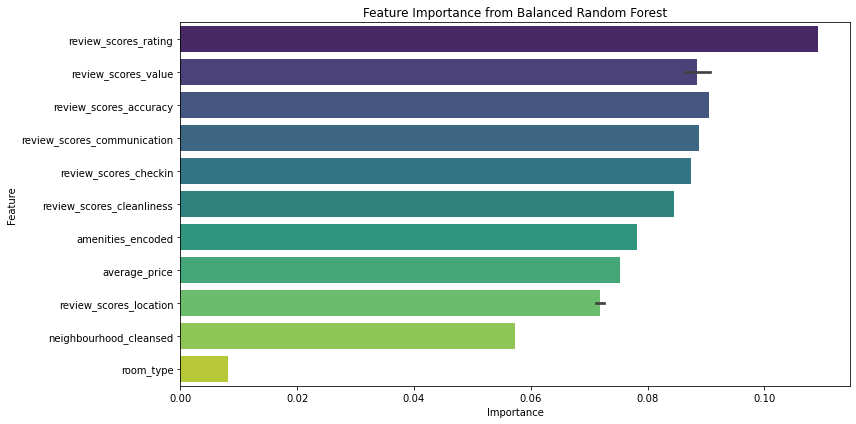

In [114]:
# Encode amenities
merged_df['amenities_encoded'] = merged_df['amenities'].apply(lambda x: len(x.split(',')))

# Convert categorical features to numerical
merged_df['room_type'] = merged_df['room_type'].astype('category').cat.codes
merged_df['neighbourhood_cleansed'] = merged_df['neighbourhood_cleansed'].astype('category').cat.codes
merged_df['price'] = merged_df['price'].replace('[\$,]', '', regex=True).astype(float)

# Prepare the data with expanded features
features = merged_df[[
    'average_price', 'review_scores_location', 'review_scores_value',
    'amenities_encoded', 'neighbourhood_cleansed', 'room_type',
    'review_scores_rating', 'review_scores_accuracy', 'review_scores_cleanliness',
    'review_scores_checkin', 'review_scores_communication', 'review_scores_location',
    'review_scores_value'
]]
target = merged_df['sentiment']

# Standardize features
scaler = StandardScaler()
features_scaled = scaler.fit_transform(features)

# Convert target to numerical labels
sentiment_mapping = {'positive': 1, 'neutral': 0, 'negative': -1}
target_mapped = target.map(sentiment_mapping)

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(features_scaled, target_mapped, test_size=0.2, random_state=42)

# Apply SMOTE to the training data
smote = SMOTE(random_state=42)
X_train_smote, y_train_smote = smote.fit_resample(X_train, y_train)

# Balanced Random Forest model
brf = BalancedRandomForestClassifier(
    random_state=42, 
    n_estimators=100,
    sampling_strategy='all',  # Set to 'all' to adopt future behavior
    replacement=True,         # Set to True to adopt future behavior
    bootstrap=False           # Set to False to adopt future behavior
)
brf.fit(X_train_smote, y_train_smote)

# Predictions
y_pred_train_brf = brf.predict(X_train_smote)
y_pred_test_brf = brf.predict(X_test)

# Classification reports
print("Training Classification Report:")
print(classification_report(y_train_smote, y_pred_train_brf))

print("Testing Classification Report:")
print(classification_report(y_test, y_pred_test_brf))

# Confusion Matrix for Training Set
cm_train = confusion_matrix(y_train_smote, y_pred_train_brf)
disp_train = ConfusionMatrixDisplay(confusion_matrix=cm_train, display_labels=['Negative', 'Neutral', 'Positive'])
disp_train.plot(cmap='Blues')
plt.title('Balanced Random Forest Training Set Confusion Matrix')
plt.show()

# Confusion Matrix for Testing Set
cm_test = confusion_matrix(y_test, y_pred_test_brf)
disp_test = ConfusionMatrixDisplay(confusion_matrix=cm_test, display_labels=['Negative', 'Neutral', 'Positive'])
disp_test.plot(cmap='Blues')
plt.title('Balanced Random Forest Testing Set Confusion Matrix')
plt.show()

# Feature Importance
feature_importance = pd.DataFrame({
    'Feature': [
        'average_price', 'review_scores_location', 'review_scores_value',
        'amenities_encoded', 'neighbourhood_cleansed', 'room_type',
        'review_scores_rating', 'review_scores_accuracy', 'review_scores_cleanliness',
        'review_scores_checkin', 'review_scores_communication', 'review_scores_location',
        'review_scores_value'
    ],
    'Importance': brf.feature_importances_
})

# Print feature importance
print("\nFeature Importances:")
print(feature_importance.sort_values(by='Importance', ascending=False))

# Visualize feature importance
plt.figure(figsize=(12, 6))
sns.barplot(x='Importance', y='Feature', data=feature_importance.sort_values(by='Importance', ascending=False), palette='viridis')
plt.title('Feature Importance from Balanced Random Forest')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.tight_layout()
plt.show()

## SMOTE + XGBoost

Training Classification Report (SMOTE):
              precision    recall  f1-score   support

    Negative       0.86      0.85      0.86     25098
     Neutral       0.83      0.85      0.84     25098
    Positive       0.83      0.83      0.83     25098

    accuracy                           0.84     75294
   macro avg       0.84      0.84      0.84     75294
weighted avg       0.84      0.84      0.84     75294

Testing Classification Report (SMOTE):
              precision    recall  f1-score   support

    Negative       0.06      0.20      0.09       171
     Neutral       0.03      0.10      0.04       173
    Positive       0.96      0.82      0.88      6290

    accuracy                           0.79      6634
   macro avg       0.35      0.37      0.34      6634
weighted avg       0.91      0.79      0.84      6634

Training Accuracy (SMOTE): 0.8433075676680745
Testing Accuracy (SMOTE): 0.7868555924027736


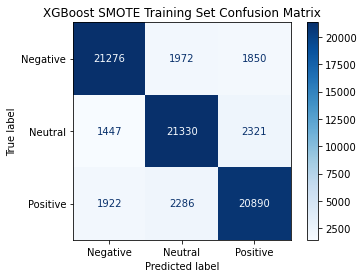

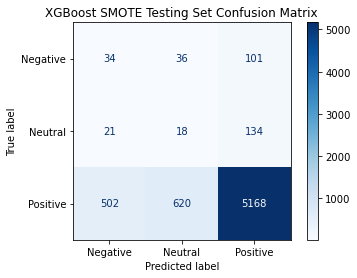


Feature Importances:
                        Feature  Importance
6          review_scores_rating    0.116253
4        neighbourhood_cleansed    0.092484
5                     room_type    0.084613
2           review_scores_value    0.083612
10  review_scores_communication    0.079879
9         review_scores_checkin    0.077057
7        review_scores_accuracy    0.073263
1        review_scores_location    0.069398
8     review_scores_cleanliness    0.069009
3             amenities_encoded    0.066928
12          review_scores_value    0.062959
11       review_scores_location    0.062392
0                 average_price    0.062153


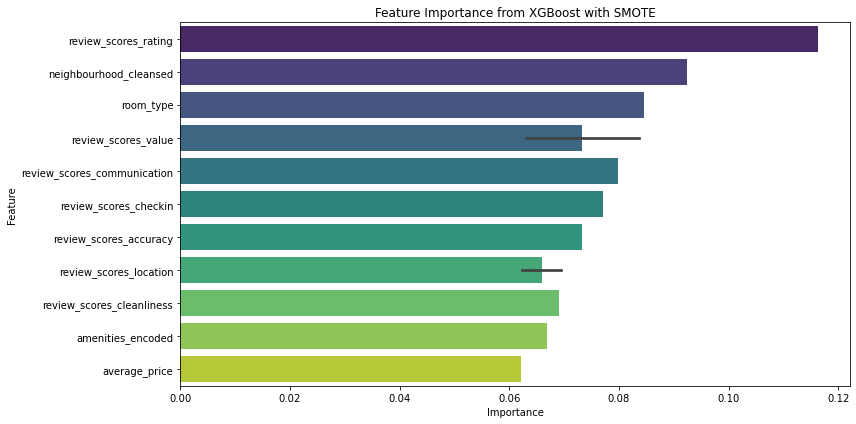

In [116]:
# Encode amenities
merged_df['amenities_encoded'] = merged_df['amenities'].apply(lambda x: len(x.split(',')))

# Convert categorical features to numerical
merged_df['room_type'] = merged_df['room_type'].astype('category').cat.codes
merged_df['neighbourhood_cleansed'] = merged_df['neighbourhood_cleansed'].astype('category').cat.codes
merged_df['price'] = merged_df['price'].replace('[\$,]', '', regex=True).astype(float)

# Prepare the data with expanded features
features = merged_df[[
    'average_price', 'review_scores_location', 'review_scores_value',
    'amenities_encoded', 'neighbourhood_cleansed', 'room_type',
    'review_scores_rating', 'review_scores_accuracy', 'review_scores_cleanliness',
    'review_scores_checkin', 'review_scores_communication', 'review_scores_location',
    'review_scores_value'
]]
target = merged_df['sentiment']

# Standardize features
scaler = StandardScaler()
features_scaled = scaler.fit_transform(features)

# Convert target to numerical labels (0, 1, 2 instead of -1, 0, 1)
sentiment_mapping = {'positive': 2, 'neutral': 1, 'negative': 0}
target_mapped = target.map(sentiment_mapping)

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(features_scaled, target_mapped, test_size=0.2, random_state=42)

# Apply SMOTE to the training data
smote = SMOTE(random_state=42)
X_train_smote, y_train_smote = smote.fit_resample(X_train, y_train)

# Train the XGBoost model with best parameters
xgb_smote = XGBClassifier(
    random_state=42, 
    colsample_bytree=0.9477831645730916, 
    learning_rate=0.1758679267213984, 
    max_depth=9, 
    n_estimators=423, 
    subsample=0.5808533263327152, 
    use_label_encoder=False, 
    eval_metric='mlogloss'
)
xgb_smote.fit(X_train_smote, y_train_smote)

# Predictions
y_pred_train_smote = xgb_smote.predict(X_train_smote)
y_pred_test_smote = xgb_smote.predict(X_test)

# Classification reports
print("Training Classification Report (SMOTE):")
print(classification_report(y_train_smote, y_pred_train_smote, target_names=['Negative', 'Neutral', 'Positive']))

print("Testing Classification Report (SMOTE):")
print(classification_report(y_test, y_pred_test_smote, target_names=['Negative', 'Neutral', 'Positive']))

# Accuracy scores
print("Training Accuracy (SMOTE):", accuracy_score(y_train_smote, y_pred_train_smote))
print("Testing Accuracy (SMOTE):", accuracy_score(y_test, y_pred_test_smote))

# Confusion Matrix for Training Set
cm_train = confusion_matrix(y_train_smote, y_pred_train_smote)
disp_train = ConfusionMatrixDisplay(confusion_matrix=cm_train, display_labels=['Negative', 'Neutral', 'Positive'])
disp_train.plot(cmap='Blues')
plt.title('XGBoost SMOTE Training Set Confusion Matrix')
plt.show()

# Confusion Matrix for Testing Set
cm_test = confusion_matrix(y_test, y_pred_test_smote)
disp_test = ConfusionMatrixDisplay(confusion_matrix=cm_test, display_labels=['Negative', 'Neutral', 'Positive'])
disp_test.plot(cmap='Blues')
plt.title('XGBoost SMOTE Testing Set Confusion Matrix')
plt.show()

# Feature Importance
feature_importance = pd.DataFrame({
    'Feature': [
        'average_price', 'review_scores_location', 'review_scores_value',
        'amenities_encoded', 'neighbourhood_cleansed', 'room_type',
        'review_scores_rating', 'review_scores_accuracy', 'review_scores_cleanliness',
        'review_scores_checkin', 'review_scores_communication', 'review_scores_location',
        'review_scores_value'
    ],
    'Importance': xgb_smote.feature_importances_
})

# Print feature importance
print("\nFeature Importances:")
print(feature_importance.sort_values(by='Importance', ascending=False))

# Visualize feature importance
plt.figure(figsize=(12, 6))
sns.barplot(x='Importance', y='Feature', data=feature_importance.sort_values(by='Importance', ascending=False), palette='viridis')
plt.title('Feature Importance from XGBoost with SMOTE')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.tight_layout()
plt.show()

## Adaptive Synthetic Sampling (ADASYN)

Training Classification Report (ADASYN):
              precision    recall  f1-score   support

    Negative       0.84      0.86      0.85     25250
     Neutral       0.84      0.83      0.84     25282
    Positive       0.83      0.82      0.83     25098

    accuracy                           0.84     75630
   macro avg       0.84      0.84      0.84     75630
weighted avg       0.84      0.84      0.84     75630

Testing Classification Report (ADASYN):
              precision    recall  f1-score   support

    Negative       0.06      0.21      0.09       171
     Neutral       0.03      0.10      0.05       173
    Positive       0.96      0.82      0.88      6290

    accuracy                           0.78      6634
   macro avg       0.35      0.38      0.34      6634
weighted avg       0.91      0.78      0.84      6634

Training Accuracy (ADASYN): 0.8384371281237604
Testing Accuracy (ADASYN): 0.7833886041603859


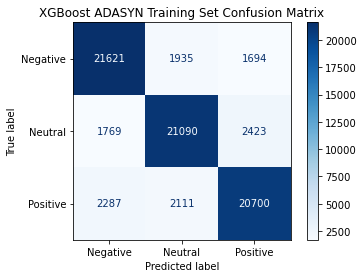

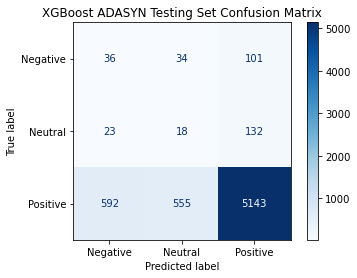


Feature Importances:
                        Feature  Importance
6          review_scores_rating    0.109713
4        neighbourhood_cleansed    0.090741
5                     room_type    0.089638
2           review_scores_value    0.085176
10  review_scores_communication    0.079253
9         review_scores_checkin    0.077110
7        review_scores_accuracy    0.074253
1        review_scores_location    0.071983
8     review_scores_cleanliness    0.069609
11       review_scores_location    0.066674
3             amenities_encoded    0.065766
0                 average_price    0.062225
12          review_scores_value    0.057860


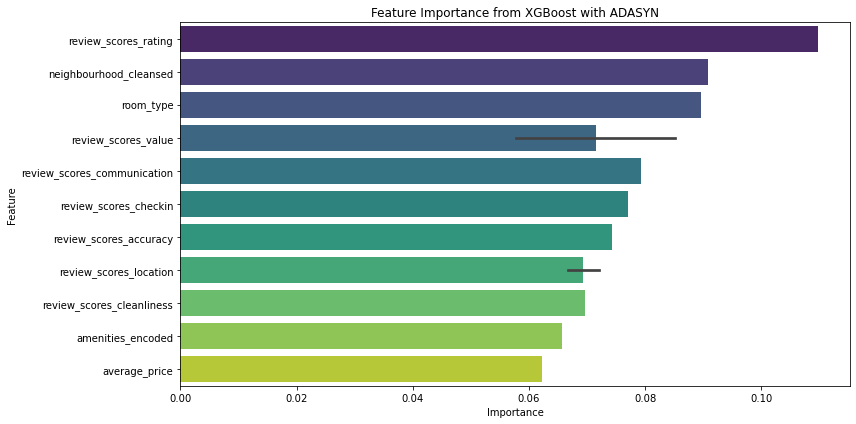

In [117]:
from imblearn.over_sampling import ADASYN

# Encode amenities
merged_df['amenities_encoded'] = merged_df['amenities'].apply(lambda x: len(x.split(',')))

# Convert categorical features to numerical
merged_df['room_type'] = merged_df['room_type'].astype('category').cat.codes
merged_df['neighbourhood_cleansed'] = merged_df['neighbourhood_cleansed'].astype('category').cat.codes
merged_df['price'] = merged_df['price'].replace('[\$,]', '', regex=True).astype(float)

# Prepare the data with expanded features
features = merged_df[[
    'average_price', 'review_scores_location', 'review_scores_value',
    'amenities_encoded', 'neighbourhood_cleansed', 'room_type',
    'review_scores_rating', 'review_scores_accuracy', 'review_scores_cleanliness',
    'review_scores_checkin', 'review_scores_communication', 'review_scores_location',
    'review_scores_value'
]]
target = merged_df['sentiment']

# Standardize features
scaler = StandardScaler()
features_scaled = scaler.fit_transform(features)

# Convert target to numerical labels (0, 1, 2 instead of -1, 0, 1)
sentiment_mapping = {'positive': 2, 'neutral': 1, 'negative': 0}
target_mapped = target.map(sentiment_mapping)

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(features_scaled, target_mapped, test_size=0.2, random_state=42)

# Apply ADASYN to the training data
adasyn = ADASYN(random_state=42)
X_train_adasyn, y_train_adasyn = adasyn.fit_resample(X_train, y_train)

# Train the XGBoost model with best parameters
xgb_adasyn = XGBClassifier(
    random_state=42, 
    colsample_bytree=0.9477831645730916, 
    learning_rate=0.1758679267213984, 
    max_depth=9, 
    n_estimators=423, 
    subsample=0.5808533263327152, 
    use_label_encoder=False, 
    eval_metric='mlogloss'
)
xgb_adasyn.fit(X_train_adasyn, y_train_adasyn)

# Predictions
y_pred_train_adasyn = xgb_adasyn.predict(X_train_adasyn)
y_pred_test_adasyn = xgb_adasyn.predict(X_test)

# Classification reports
print("Training Classification Report (ADASYN):")
print(classification_report(y_train_adasyn, y_pred_train_adasyn, target_names=['Negative', 'Neutral', 'Positive']))

print("Testing Classification Report (ADASYN):")
print(classification_report(y_test, y_pred_test_adasyn, target_names=['Negative', 'Neutral', 'Positive']))

# Accuracy scores
print("Training Accuracy (ADASYN):", accuracy_score(y_train_adasyn, y_pred_train_adasyn))
print("Testing Accuracy (ADASYN):", accuracy_score(y_test, y_pred_test_adasyn))

# Confusion Matrix for Training Set
cm_train = confusion_matrix(y_train_adasyn, y_pred_train_adasyn)
disp_train = ConfusionMatrixDisplay(confusion_matrix=cm_train, display_labels=['Negative', 'Neutral', 'Positive'])
disp_train.plot(cmap='Blues')
plt.title('XGBoost ADASYN Training Set Confusion Matrix')
plt.show()

# Confusion Matrix for Testing Set
cm_test = confusion_matrix(y_test, y_pred_test_adasyn)
disp_test = ConfusionMatrixDisplay(confusion_matrix=cm_test, display_labels=['Negative', 'Neutral', 'Positive'])
disp_test.plot(cmap='Blues')
plt.title('XGBoost ADASYN Testing Set Confusion Matrix')
plt.show()

# Feature Importance
feature_importance = pd.DataFrame({
    'Feature': [
        'average_price', 'review_scores_location', 'review_scores_value',
        'amenities_encoded', 'neighbourhood_cleansed', 'room_type',
        'review_scores_rating', 'review_scores_accuracy', 'review_scores_cleanliness',
        'review_scores_checkin', 'review_scores_communication', 'review_scores_location',
        'review_scores_value'
    ],
    'Importance': xgb_adasyn.feature_importances_
})

# Print feature importance
print("\nFeature Importances:")
print(feature_importance.sort_values(by='Importance', ascending=False))

# Visualize feature importance
plt.figure(figsize=(12, 6))
sns.barplot(x='Importance', y='Feature', data=feature_importance.sort_values(by='Importance', ascending=False), palette='viridis')
plt.title('Feature Importance from XGBoost with ADASYN')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.tight_layout()
plt.show()

## SMOTEENN : Synthetic Minority Over-sampling Technique + Edited Nearest Neighbors

**Purpose:** To address class imbalance by combining over-sampling (SMOTE) and under-sampling (ENN) techniques.

**How it works:**

**SMOTE:** First, SMOTE is applied to create synthetic samples of the minority class, thereby increasing the representation of the minority class.

**ENN:** After SMOTE, ENN is applied to the resulting dataset. ENN removes noisy or borderline examples from both the majority and minority classes, which helps in cleaning the dataset.

This can lead to better model performance, especially when dealing with imbalanced datasets.

Training Classification Report (SMOTEENN):
              precision    recall  f1-score   support

    Negative       1.00      1.00      1.00     13010
     Neutral       1.00      1.00      1.00     12704
    Positive       1.00      1.00      1.00     21481

    accuracy                           1.00     47195
   macro avg       1.00      1.00      1.00     47195
weighted avg       1.00      1.00      1.00     47195

Testing Classification Report (SMOTEENN):
              precision    recall  f1-score   support

    Negative       0.07      0.19      0.10       171
     Neutral       0.03      0.10      0.05       173
    Positive       0.95      0.86      0.91      6290

    accuracy                           0.82      6634
   macro avg       0.35      0.38      0.35      6634
weighted avg       0.91      0.82      0.86      6634

Training Accuracy (SMOTEENN): 0.9999364339442738
Testing Accuracy (SMOTEENN): 0.8239372927343985


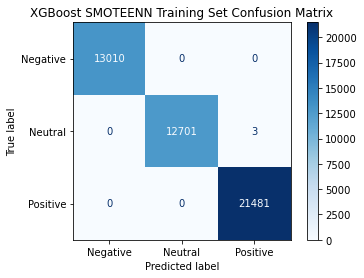

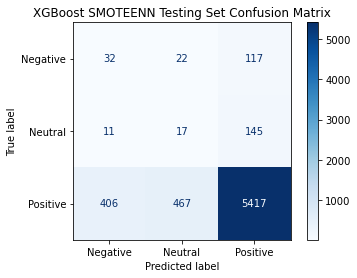


Feature Importances:
                        Feature  Importance
6          review_scores_rating    0.117843
2           review_scores_value    0.096369
4        neighbourhood_cleansed    0.094978
10  review_scores_communication    0.093334
5                     room_type    0.089426
0                 average_price    0.072449
1        review_scores_location    0.070515
9         review_scores_checkin    0.067410
7        review_scores_accuracy    0.066485
8     review_scores_cleanliness    0.062569
3             amenities_encoded    0.061229
12          review_scores_value    0.059808
11       review_scores_location    0.047585


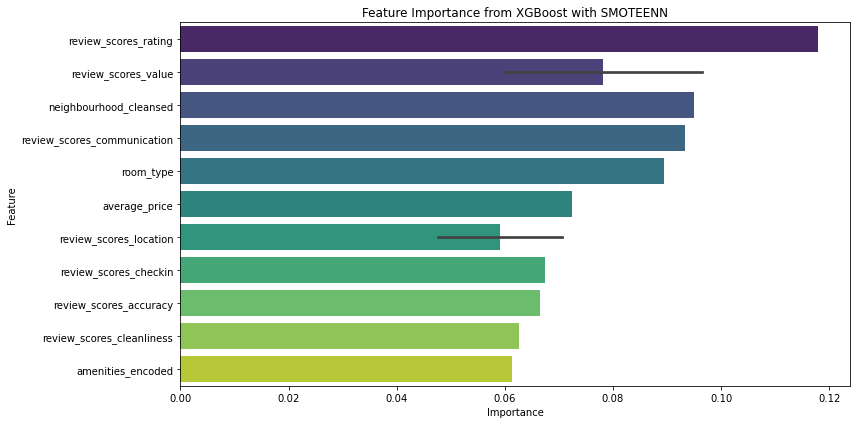

In [118]:
# Encode amenities
merged_df['amenities_encoded'] = merged_df['amenities'].apply(lambda x: len(x.split(',')))

# Convert categorical features to numerical
merged_df['room_type'] = merged_df['room_type'].astype('category').cat.codes
merged_df['neighbourhood_cleansed'] = merged_df['neighbourhood_cleansed'].astype('category').cat.codes
merged_df['price'] = merged_df['price'].replace('[\$,]', '', regex=True).astype(float)

# Prepare the data with expanded features
features = merged_df[[
    'average_price', 'review_scores_location', 'review_scores_value',
    'amenities_encoded', 'neighbourhood_cleansed', 'room_type',
    'review_scores_rating', 'review_scores_accuracy', 'review_scores_cleanliness',
    'review_scores_checkin', 'review_scores_communication', 'review_scores_location',
    'review_scores_value'
]]
target = merged_df['sentiment']

# Standardize features
scaler = StandardScaler()
features_scaled = scaler.fit_transform(features)

# Convert target to numerical labels (0, 1, 2 instead of -1, 0, 1)
sentiment_mapping = {'positive': 2, 'neutral': 1, 'negative': 0}
target_mapped = target.map(sentiment_mapping)

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(features_scaled, target_mapped, test_size=0.2, random_state=42)

# Apply SMOTEENN to the training data
smoteenn = SMOTEENN(random_state=42)
X_train_smoteenn, y_train_smoteenn = smoteenn.fit_resample(X_train, y_train)

# Train the XGBoost model with best parameters
xgb_smoteenn = XGBClassifier(
    random_state=42, 
    colsample_bytree=0.9477831645730916, 
    learning_rate=0.1758679267213984, 
    max_depth=9, 
    n_estimators=423, 
    subsample=0.5808533263327152, 
    use_label_encoder=False, 
    eval_metric='mlogloss'
)
xgb_smoteenn.fit(X_train_smoteenn, y_train_smoteenn)

# Predictions
y_pred_train_smoteenn = xgb_smoteenn.predict(X_train_smoteenn)
y_pred_test_smoteenn = xgb_smoteenn.predict(X_test)

# Classification reports
print("Training Classification Report (SMOTEENN):")
print(classification_report(y_train_smoteenn, y_pred_train_smoteenn, target_names=['Negative', 'Neutral', 'Positive']))

print("Testing Classification Report (SMOTEENN):")
print(classification_report(y_test, y_pred_test_smoteenn, target_names=['Negative', 'Neutral', 'Positive']))

# Accuracy scores
print("Training Accuracy (SMOTEENN):", accuracy_score(y_train_smoteenn, y_pred_train_smoteenn))
print("Testing Accuracy (SMOTEENN):", accuracy_score(y_test, y_pred_test_smoteenn))

# Confusion Matrix for Training Set
cm_train = confusion_matrix(y_train_smoteenn, y_pred_train_smoteenn)
disp_train = ConfusionMatrixDisplay(confusion_matrix=cm_train, display_labels=['Negative', 'Neutral', 'Positive'])
disp_train.plot(cmap='Blues')
plt.title('XGBoost SMOTEENN Training Set Confusion Matrix')
plt.show()

# Confusion Matrix for Testing Set
cm_test = confusion_matrix(y_test, y_pred_test_smoteenn)
disp_test = ConfusionMatrixDisplay(confusion_matrix=cm_test, display_labels=['Negative', 'Neutral', 'Positive'])
disp_test.plot(cmap='Blues')
plt.title('XGBoost SMOTEENN Testing Set Confusion Matrix')
plt.show()

# Feature Importance
feature_importance = pd.DataFrame({
    'Feature': [
        'average_price', 'review_scores_location', 'review_scores_value',
        'amenities_encoded', 'neighbourhood_cleansed', 'room_type',
        'review_scores_rating', 'review_scores_accuracy', 'review_scores_cleanliness',
        'review_scores_checkin', 'review_scores_communication', 'review_scores_location',
        'review_scores_value'
    ],
    'Importance': xgb_smoteenn.feature_importances_
})

# Print feature importance
print("\nFeature Importances:")
print(feature_importance.sort_values(by='Importance', ascending=False))

# Visualize feature importance
plt.figure(figsize=(12, 6))
sns.barplot(x='Importance', y='Feature', data=feature_importance.sort_values(by='Importance', ascending=False), palette='viridis')
plt.title('Feature Importance from XGBoost with SMOTEENN')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.tight_layout()
plt.show()

## Summary

**Model Performance:**

- The model performs exceptionally well on the training data, indicating potential overfitting.

- On the testing set, the model performs very well for the positive sentiment class but struggles significantly with negative and neutral sentiments.

**Class Imbalance Impact:**

- Despite using SMOTEENN, the model still struggles with predicting minority classes on the testing set. The positive sentiment class dominates, leading to high precision and recall for this class but poor performance for others.

**Overfitting:** 

- The significant difference between training and testing performance suggests that the model might be overfitting to the resampled training data.

## Cross-Tabulation 

Training Classification Report (SMOTETomek):
              precision    recall  f1-score   support

    Negative       0.87      0.86      0.87     23894
     Neutral       0.84      0.86      0.85     23894
    Positive       0.83      0.83      0.83     25098

    accuracy                           0.85     72886
   macro avg       0.85      0.85      0.85     72886
weighted avg       0.85      0.85      0.85     72886

Testing Classification Report (SMOTETomek):
              precision    recall  f1-score   support

    Negative       0.06      0.20      0.10       171
     Neutral       0.03      0.11      0.04       173
    Positive       0.96      0.82      0.88      6290

    accuracy                           0.79      6634
   macro avg       0.35      0.38      0.34      6634
weighted avg       0.91      0.79      0.84      6634

Training Accuracy (SMOTETomek): 0.8493949455313777
Testing Accuracy (SMOTETomek): 0.7874585468797106


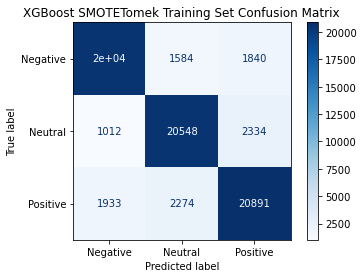

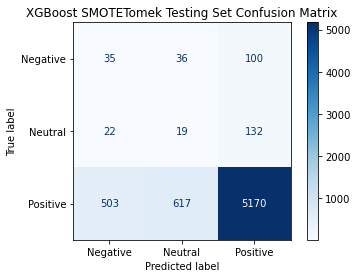


Feature Importances:
                        Feature  Importance
6          review_scores_rating    0.118907
4        neighbourhood_cleansed    0.089857
5                     room_type    0.084590
10  review_scores_communication    0.079302
2           review_scores_value    0.078934
9         review_scores_checkin    0.076282
7        review_scores_accuracy    0.072310
1        review_scores_location    0.071765
8     review_scores_cleanliness    0.069522
3             amenities_encoded    0.069392
11       review_scores_location    0.064380
12          review_scores_value    0.062404
0                 average_price    0.062355


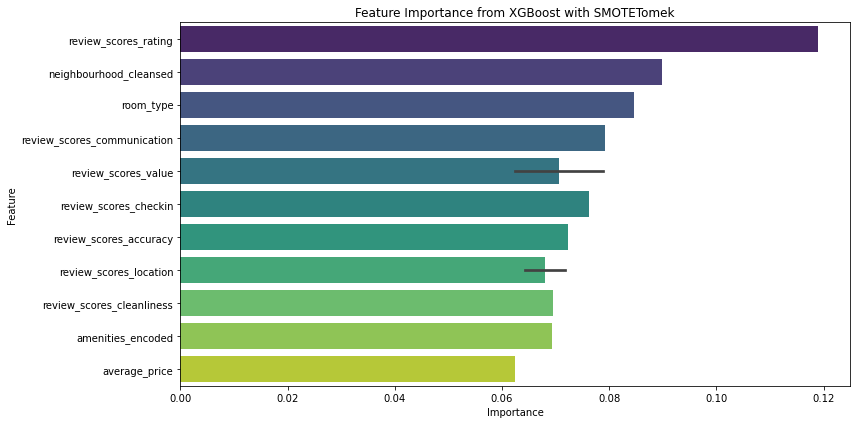

In [119]:
from imblearn.combine import SMOTETomek

# Encode amenities
merged_df['amenities_encoded'] = merged_df['amenities'].apply(lambda x: len(x.split(',')))

# Convert categorical features to numerical
merged_df['room_type'] = merged_df['room_type'].astype('category').cat.codes
merged_df['neighbourhood_cleansed'] = merged_df['neighbourhood_cleansed'].astype('category').cat.codes
merged_df['price'] = merged_df['price'].replace('[\$,]', '', regex=True).astype(float)

# Prepare the data with expanded features
features = merged_df[[
    'average_price', 'review_scores_location', 'review_scores_value',
    'amenities_encoded', 'neighbourhood_cleansed', 'room_type',
    'review_scores_rating', 'review_scores_accuracy', 'review_scores_cleanliness',
    'review_scores_checkin', 'review_scores_communication', 'review_scores_location',
    'review_scores_value'
]]
target = merged_df['sentiment']

# Standardize features
scaler = StandardScaler()
features_scaled = scaler.fit_transform(features)

# Convert target to numerical labels (0, 1, 2 instead of -1, 0, 1)
sentiment_mapping = {'positive': 2, 'neutral': 1, 'negative': 0}
target_mapped = target.map(sentiment_mapping)

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(features_scaled, target_mapped, test_size=0.2, random_state=42)

# Apply SMOTETomek to the training data
smotetomek = SMOTETomek(random_state=42)
X_train_smotetomek, y_train_smotetomek = smotetomek.fit_resample(X_train, y_train)

# Train the XGBoost model with best parameters
xgb_smotetomek = XGBClassifier(
    random_state=42, 
    colsample_bytree=0.9477831645730916, 
    learning_rate=0.1758679267213984, 
    max_depth=9, 
    n_estimators=423, 
    subsample=0.5808533263327152, 
    use_label_encoder=False, 
    eval_metric='mlogloss'
)
xgb_smotetomek.fit(X_train_smotetomek, y_train_smotetomek)

# Predictions
y_pred_train_smotetomek = xgb_smotetomek.predict(X_train_smotetomek)
y_pred_test_smotetomek = xgb_smotetomek.predict(X_test)

# Classification reports
print("Training Classification Report (SMOTETomek):")
print(classification_report(y_train_smotetomek, y_pred_train_smotetomek, target_names=['Negative', 'Neutral', 'Positive']))

print("Testing Classification Report (SMOTETomek):")
print(classification_report(y_test, y_pred_test_smotetomek, target_names=['Negative', 'Neutral', 'Positive']))

# Accuracy scores
print("Training Accuracy (SMOTETomek):", accuracy_score(y_train_smotetomek, y_pred_train_smotetomek))
print("Testing Accuracy (SMOTETomek):", accuracy_score(y_test, y_pred_test_smotetomek))

# Confusion Matrix for Training Set
cm_train = confusion_matrix(y_train_smotetomek, y_pred_train_smotetomek)
disp_train = ConfusionMatrixDisplay(confusion_matrix=cm_train, display_labels=['Negative', 'Neutral', 'Positive'])
disp_train.plot(cmap='Blues')
plt.title('XGBoost SMOTETomek Training Set Confusion Matrix')
plt.show()

# Confusion Matrix for Testing Set
cm_test = confusion_matrix(y_test, y_pred_test_smotetomek)
disp_test = ConfusionMatrixDisplay(confusion_matrix=cm_test, display_labels=['Negative', 'Neutral', 'Positive'])
disp_test.plot(cmap='Blues')
plt.title('XGBoost SMOTETomek Testing Set Confusion Matrix')
plt.show()

# Feature Importance
feature_importance = pd.DataFrame({
    'Feature': [
        'average_price', 'review_scores_location', 'review_scores_value',
        'amenities_encoded', 'neighbourhood_cleansed', 'room_type',
        'review_scores_rating', 'review_scores_accuracy', 'review_scores_cleanliness',
        'review_scores_checkin', 'review_scores_communication', 'review_scores_location',
        'review_scores_value'
    ],
    'Importance': xgb_smotetomek.feature_importances_
})

# Print feature importance
print("\nFeature Importances:")
print(feature_importance.sort_values(by='Importance', ascending=False))

# Visualize feature importance
plt.figure(figsize=(12, 6))
sns.barplot(x='Importance', y='Feature', data=feature_importance.sort_values(by='Importance', ascending=False), palette='viridis')
plt.title('Feature Importance from XGBoost with SMOTETomek')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.tight_layout()
plt.show()

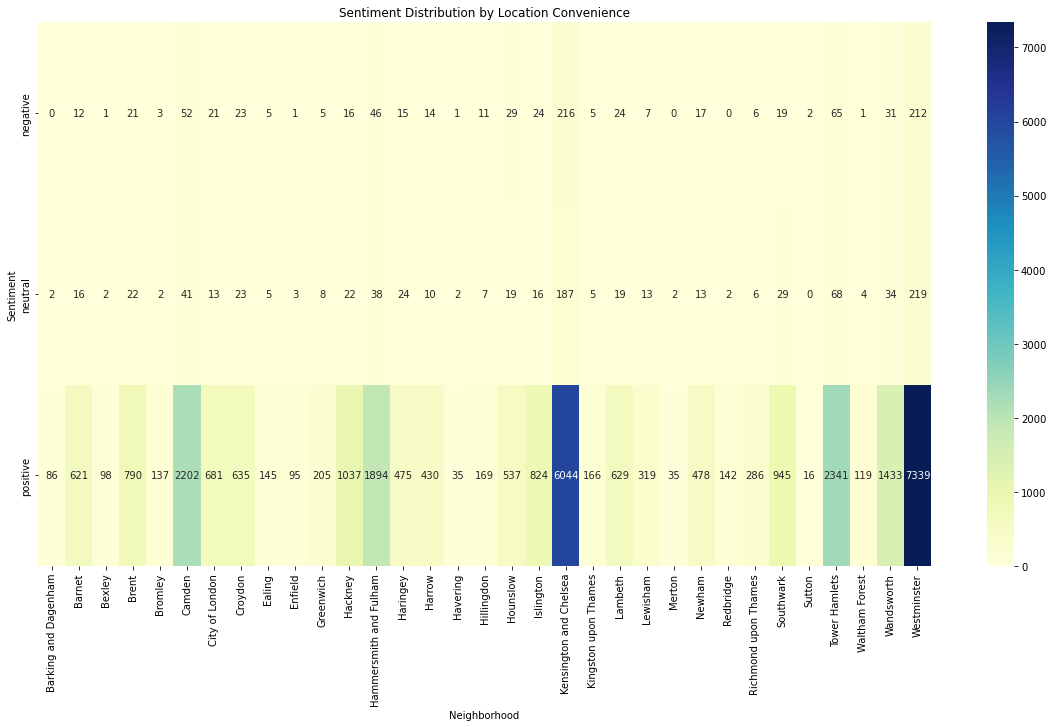

In [18]:
# Cross-Tabulation for Location Convenience and Sentiment
location_sentiment_ct = pd.crosstab(merged_df['sentiment'], merged_df['neighbourhood_cleansed'])
plt.figure(figsize=(20, 10))
sns.heatmap(location_sentiment_ct, cmap="YlGnBu", annot=True, fmt="d")
plt.title('Sentiment Distribution by Location Convenience')
plt.xlabel('Neighborhood')
plt.ylabel('Sentiment')
plt.xticks(rotation=90)
plt.show()

## Interpretation of the Result

The heatmap shows the distribution of sentiments (negative, neutral, and positive) across various neighborhoods. 

**Color Intensity:** The intensity of the color represents the number of reviews. Darker colors indicate a higher number of reviews for that sentiment in that neighborhood.

**Positive Sentiment (Class 2):**

- Kensington and Chelsea and Westminster have the highest number of positive reviews, indicating that these neighborhoods are highly favored by guests.
- Other neighborhoods like Camden, City of London, and Tower Hamlets also have a significant number of positive reviews.

**Neutral Sentiment (Class 1):**

- Similar to positive sentiment, Kensington and Chelsea and Westminster also show higher counts of neutral reviews.
- City of London, Camden, and Tower Hamlets have a notable number of neutral reviews, suggesting a balanced sentiment in these areas.

**Negative Sentiment (Class 0):**

- While negative sentiments are generally lower across all neighborhoods, Kensington and Chelsea and Westminster again have higher counts, which could be due to the higher volume of reviews in these areas.
- Camden and City of London show relatively higher negative review counts compared to other neighborhoods.

**General Trends:**

- Kensington and Chelsea and Westminster appear to have the highest review volumes, both positive and negative. This might indicate these are popular areas with a high number of guests.

- Most neighborhoods have a higher count of positive reviews compared to negative and neutral reviews, suggesting a generally positive sentiment towards the accommodations.

**Conclusion**

The heatmap provides a clear visualization of how sentiment is distributed across different neighborhoods. 

- The popularity of certain neighborhoods like Kensington and Chelsea, Westminster, Camden, City of London, and Tower Hamlets.
- General positive sentiment towards accommodations, with some neighborhoods showing higher negative sentiment, potentially indicating areas for improvement.

## Model Evaluation by ROC-AUC curve

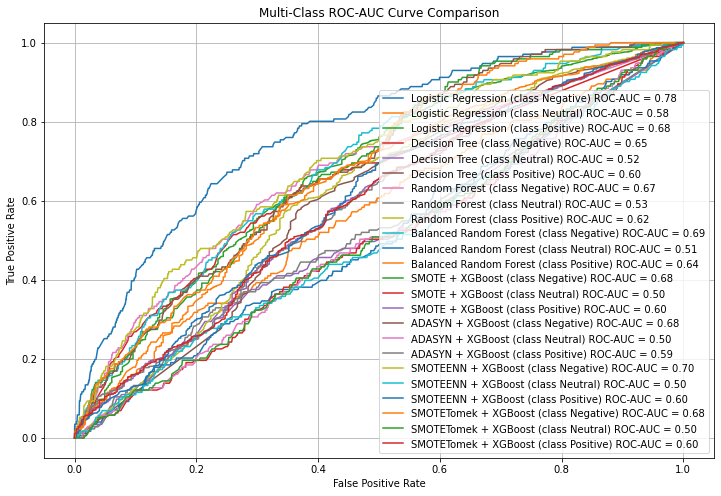

In [125]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from imblearn.ensemble import BalancedRandomForestClassifier
from xgboost import XGBClassifier
from sklearn.metrics import roc_auc_score, roc_curve, auc, RocCurveDisplay
from imblearn.over_sampling import SMOTE, ADASYN
from imblearn.combine import SMOTEENN, SMOTETomek
from sklearn.preprocessing import label_binarize

# Assuming merged_df is already defined and loaded

# Encode amenities
merged_df['amenities_encoded'] = merged_df['amenities'].apply(lambda x: len(x.split(',')))

# Convert categorical features to numerical
merged_df['room_type'] = merged_df['room_type'].astype('category').cat.codes
merged_df['neighbourhood_cleansed'] = merged_df['neighbourhood_cleansed'].astype('category').cat.codes
merged_df['price'] = merged_df['price'].replace('[\$,]', '', regex=True).astype(float)

# Prepare the data with expanded features
features = merged_df[[
    'average_price', 'review_scores_location', 'review_scores_value',
    'amenities_encoded', 'neighbourhood_cleansed', 'room_type',
    'review_scores_rating', 'review_scores_accuracy', 'review_scores_cleanliness',
    'review_scores_checkin', 'review_scores_communication', 'review_scores_location',
    'review_scores_value'
]]
target = merged_df['sentiment']

# Standardize features
scaler = StandardScaler()
features_scaled = scaler.fit_transform(features)

# Convert target to numerical labels (0, 1, 2 instead of -1, 0, 1)
sentiment_mapping = {'positive': 2, 'neutral': 1, 'negative': 0}
target_mapped = target.map(sentiment_mapping)

# Binarize the output for ROC-AUC computation
y_binarized = label_binarize(target_mapped, classes=[0, 1, 2])

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(features_scaled, target_mapped, test_size=0.2, random_state=42)

# Define a function to plot ROC-AUC curves for multi-class classification
def plot_roc_auc_multiclass(models, X_test, y_test, class_names):
    plt.figure(figsize=(12, 8))
    
    # Binarize the test labels for each class
    y_test_binarized = label_binarize(y_test, classes=[0, 1, 2])
    
    for model, label in models:
        y_prob = model.predict_proba(X_test)
        for i in range(len(class_names)):
            fpr, tpr, _ = roc_curve(y_test_binarized[:, i], y_prob[:, i])
            auc_score = auc(fpr, tpr)
            plt.plot(fpr, tpr, label=f'{label} (class {class_names[i]}) ROC-AUC = {auc_score:.2f}')
    
    plt.title('Multi-Class ROC-AUC Curve Comparison')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.legend(loc='best')
    plt.grid(True)
    plt.show()

# Logistic Regression
log_reg = LogisticRegression(max_iter=1000, random_state=42)
log_reg.fit(X_train, y_train)

# Decision Tree
tree_model = DecisionTreeClassifier(random_state=42)
tree_model.fit(X_train, y_train)

# Random Forest
forest_model = RandomForestClassifier(random_state=42, n_estimators=100)
forest_model.fit(X_train, y_train)

# Balanced Random Forest
brf = BalancedRandomForestClassifier(random_state=42, n_estimators=100, sampling_strategy='all', replacement=True, bootstrap=False)
brf.fit(X_train, y_train)

# SMOTE Technique
smote = SMOTE(random_state=42)
X_train_smote, y_train_smote = smote.fit_resample(X_train, y_train)

# XGBoost with SMOTE
xgb_smote = XGBClassifier(
    random_state=42,
    colsample_bytree=0.9477831645730916,
    learning_rate=0.1758679267213984,
    max_depth=9,
    n_estimators=423,
    subsample=0.5808533263327152,
    use_label_encoder=False,
    eval_metric='mlogloss'
)
xgb_smote.fit(X_train_smote, y_train_smote)

# ADASYN Technique
adasyn = ADASYN(random_state=42)
X_train_adasyn, y_train_adasyn = adasyn.fit_resample(X_train, y_train)

# XGBoost with ADASYN
xgb_adasyn = XGBClassifier(
    random_state=42,
    colsample_bytree=0.9477831645730916,
    learning_rate=0.1758679267213984,
    max_depth=9,
    n_estimators=423,
    subsample=0.5808533263327152,
    use_label_encoder=False,
    eval_metric='mlogloss'
)
xgb_adasyn.fit(X_train_adasyn, y_train_adasyn)

# SMOTEENN Technique
smoteenn = SMOTEENN(random_state=42)
X_train_smoteenn, y_train_smoteenn = smoteenn.fit_resample(X_train, y_train)

# XGBoost with SMOTEENN
xgb_smoteenn = XGBClassifier(
    random_state=42,
    colsample_bytree=0.9477831645730916,
    learning_rate=0.1758679267213984,
    max_depth=9,
    n_estimators=423,
    subsample=0.5808533263327152,
    use_label_encoder=False,
    eval_metric='mlogloss'
)
xgb_smoteenn.fit(X_train_smoteenn, y_train_smoteenn)

# SMOTETomek Technique
smotetomek = SMOTETomek(random_state=42)
X_train_smotetomek, y_train_smotetomek = smotetomek.fit_resample(X_train, y_train)

# XGBoost with SMOTETomek
xgb_smotetomek = XGBClassifier(
    random_state=42,
    colsample_bytree=0.9477831645730916,
    learning_rate=0.1758679267213984,
    max_depth=9,
    n_estimators=423,
    subsample=0.5808533263327152,
    use_label_encoder=False,
    eval_metric='mlogloss'
)
xgb_smotetomek.fit(X_train_smotetomek, y_train_smotetomek)

# List of models for comparison
models = [
    (log_reg, 'Logistic Regression'),
    (tree_model, 'Decision Tree'),
    (forest_model, 'Random Forest'),
    (brf, 'Balanced Random Forest'),
    (xgb_smote, 'SMOTE + XGBoost'),
    (xgb_adasyn, 'ADASYN + XGBoost'),
    (xgb_smoteenn, 'SMOTEENN + XGBoost'),
    (xgb_smotetomek, 'SMOTETomek + XGBoost')
]

# Plot ROC-AUC curves for each model
class_names = ['Negative', 'Neutral', 'Positive']
plot_roc_auc_multiclass(models, X_test, y_test, class_names)
